In [1]:
!pip install tensorflow

In [2]:
import json
import os
import fnmatch
import pandas as pd
import seaborn
import numpy as np

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


# Unzip NASLib/run/results/zc_ensembles.zip before running the code

In [3]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED = 9000
N_SEEDS = 10

def find_files(src='../run/results/zc_ensemble', fname='*events.out.tfevents.*'):
    matches = []
    for root, dirnames, filenames in os.walk(src):
        for filename in fnmatch.filter(filenames, fname):
            matches.append(os.path.join(root, filename))

    return matches

def read_file(event_file, tag):
    vals = []
    for e in tf.train.summary_iterator(event_file):
        for v in e.summary.value:
            if v.tag == tag:
                vals.append(v.simple_value)
    return vals

In [4]:
all_files = find_files()

In [5]:
all_files[0]

'../run/results/zc_ensemble/transbench101_micro/class_scene/zc/9000/fisher-flops-grad_norm-grasp-jacov-l2_norm-nwot-params-plain-snip/events.out.tfevents.1652913172.kisexe10.3955346.0'

In [6]:
def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        components = file.split('/')
        zc_names, seed, dataset, search_space = components[-2], components[-3], components[-5], components[-6]

        val_accuracies = read_file(file, "Validation accuracy (top 1)")
        train_accuracies = read_file(file, "Train accuracy (top 1)")
        
        if len(val_accuracies) == 0 or len(train_accuracies) == 0:
            continue
        
        record = {
            'search_space': search_space,
            'dataset': dataset,
            'seed': seed,
            'zc_names': zc_names,
            'val_accs': val_accuracies,
            'train_accs': train_accuracies,
        }

        data.append(record)

    return data

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def get_val_train_accs(df, search_space, dataset):
    df_ = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)]
    
    seed_val_accs = []
    seed_train_accs = []

    for seed in range(START_SEED, START_SEED + N_SEEDS):
        try:
            vals = df_[df_['seed'] == str(seed)]['val_accs'].item()
            train_accs = df_[df_['seed'] == str(seed)]['train_accs'].item()
            seed_val_accs.append(vals)
            seed_train_accs.append(train_accs)
        except:
            print(df_[df_['seed'] == str(seed)]['val_accs'])
    
    return np.array(seed_val_accs), np.array(seed_train_accs)

def plot(x, title, xlabel, ylabel, figsize=(18, 12)):
    
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_mean)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.fill_between(range(len(x_mean)), x_mean+x_std, x_mean-x_std, alpha=0.6)

def plot_for_search_space(df, search_space):
    for dataset in BENCHMARKS[search_space]:
        val_accs, train_accs = get_val_train_accs(df, search_space, dataset)
        plot(val_accs, f'{LABELS[search_space]} {LABELS[dataset]}', 'Epochs', 'Validation Accuracy (Top 1)')


In [7]:
df = make_df(all_files)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [8]:
df.dataset.unique()

array(['class_scene', 'segmentsemantic', 'normal', 'class_object',
       'autoencoder', 'jigsaw', 'room_layout', 'cifar10',
       'ImageNet16-120', 'cifar100'], dtype=object)

In [9]:
df

,search_space,dataset,seed,zc_names,val_accs,train_accs
0,transbench101_micro,class_scene,9000,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[51.7714958190918, 52.935909271240234, 52.9359...","[88.72750091552734, 90.15499877929688, 90.1549..."
1,transbench101_micro,class_scene,9001,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[30.96138572692871, 52.970741271972656, 52.970...","[58.394996643066406, 91.13999938964844, 91.139..."
2,transbench101_micro,class_scene,9005,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[35.97731018066406, 52.498008728027344, 52.498...","[74.96749877929688, 89.27124786376953, 89.2712..."
3,transbench101_micro,class_scene,9002,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[30.752389907836914, 50.81110763549805, 50.811...","[58.693748474121094, 89.81749725341797, 89.817..."
4,transbench101_micro,class_scene,9007,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[52.73188781738281, 52.73188781738281, 52.7318...","[89.45249938964844, 89.45249938964844, 89.4524..."
5,transbench101_micro,class_scene,9004,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[50.7414436340332, 51.821258544921875, 53.2046...","[90.22750091552734, 90.4937515258789, 91.30124..."
6,transbench101_micro,class_scene,9008,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[51.323646545410156, 52.935909271240234, 53.38...","[89.10124969482422, 89.4749984741211, 90.56999..."
7,transbench101_micro,class_scene,9009,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[52.89609909057617, 52.89609909057617, 54.0953...","[89.53499603271484, 89.53499603271484, 91.5162..."
8,transbench101_micro,class_scene,9003,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[52.12480163574219, 52.12480163574219, 52.8612...","[89.32374572753906, 89.32374572753906, 89.25, ..."
9,transbench101_micro,class_scene,9006,fisher-flops-grad_norm-grasp-jacov-l2_norm-nwo...,"[52.522891998291016, 53.632564544677734, 53.63...","[90.32624816894531, 90.82125091552734, 90.8212..."


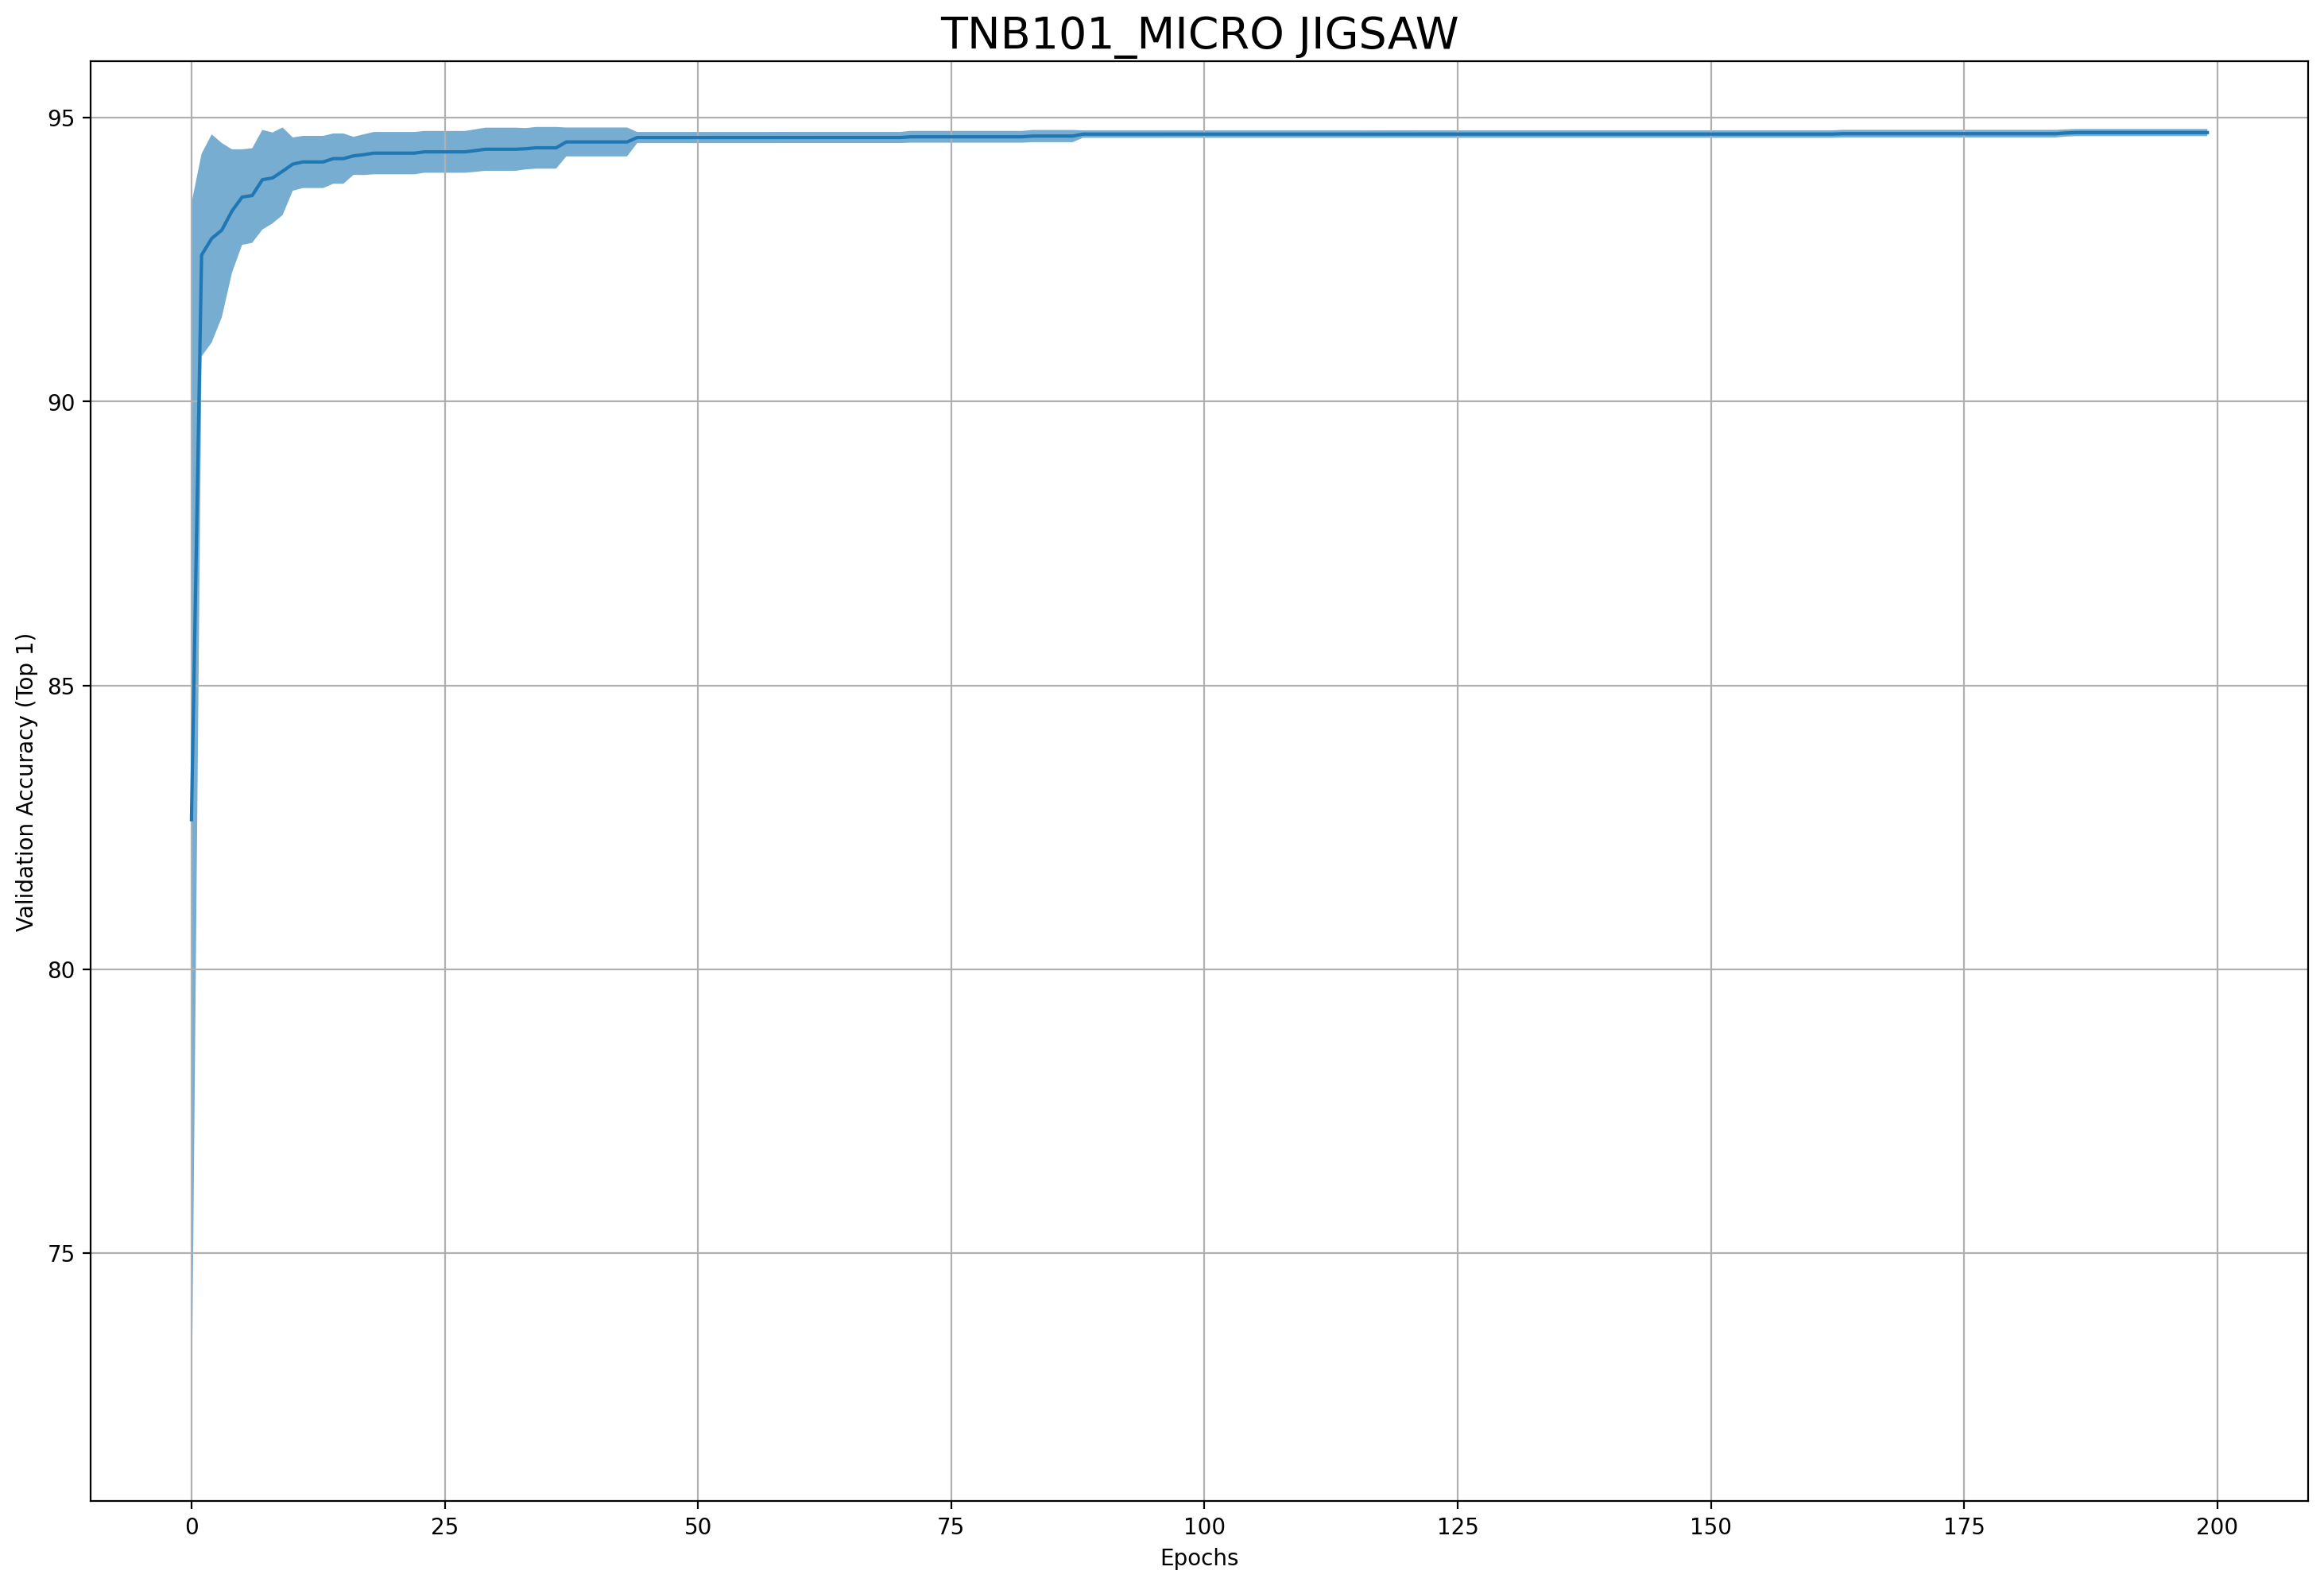

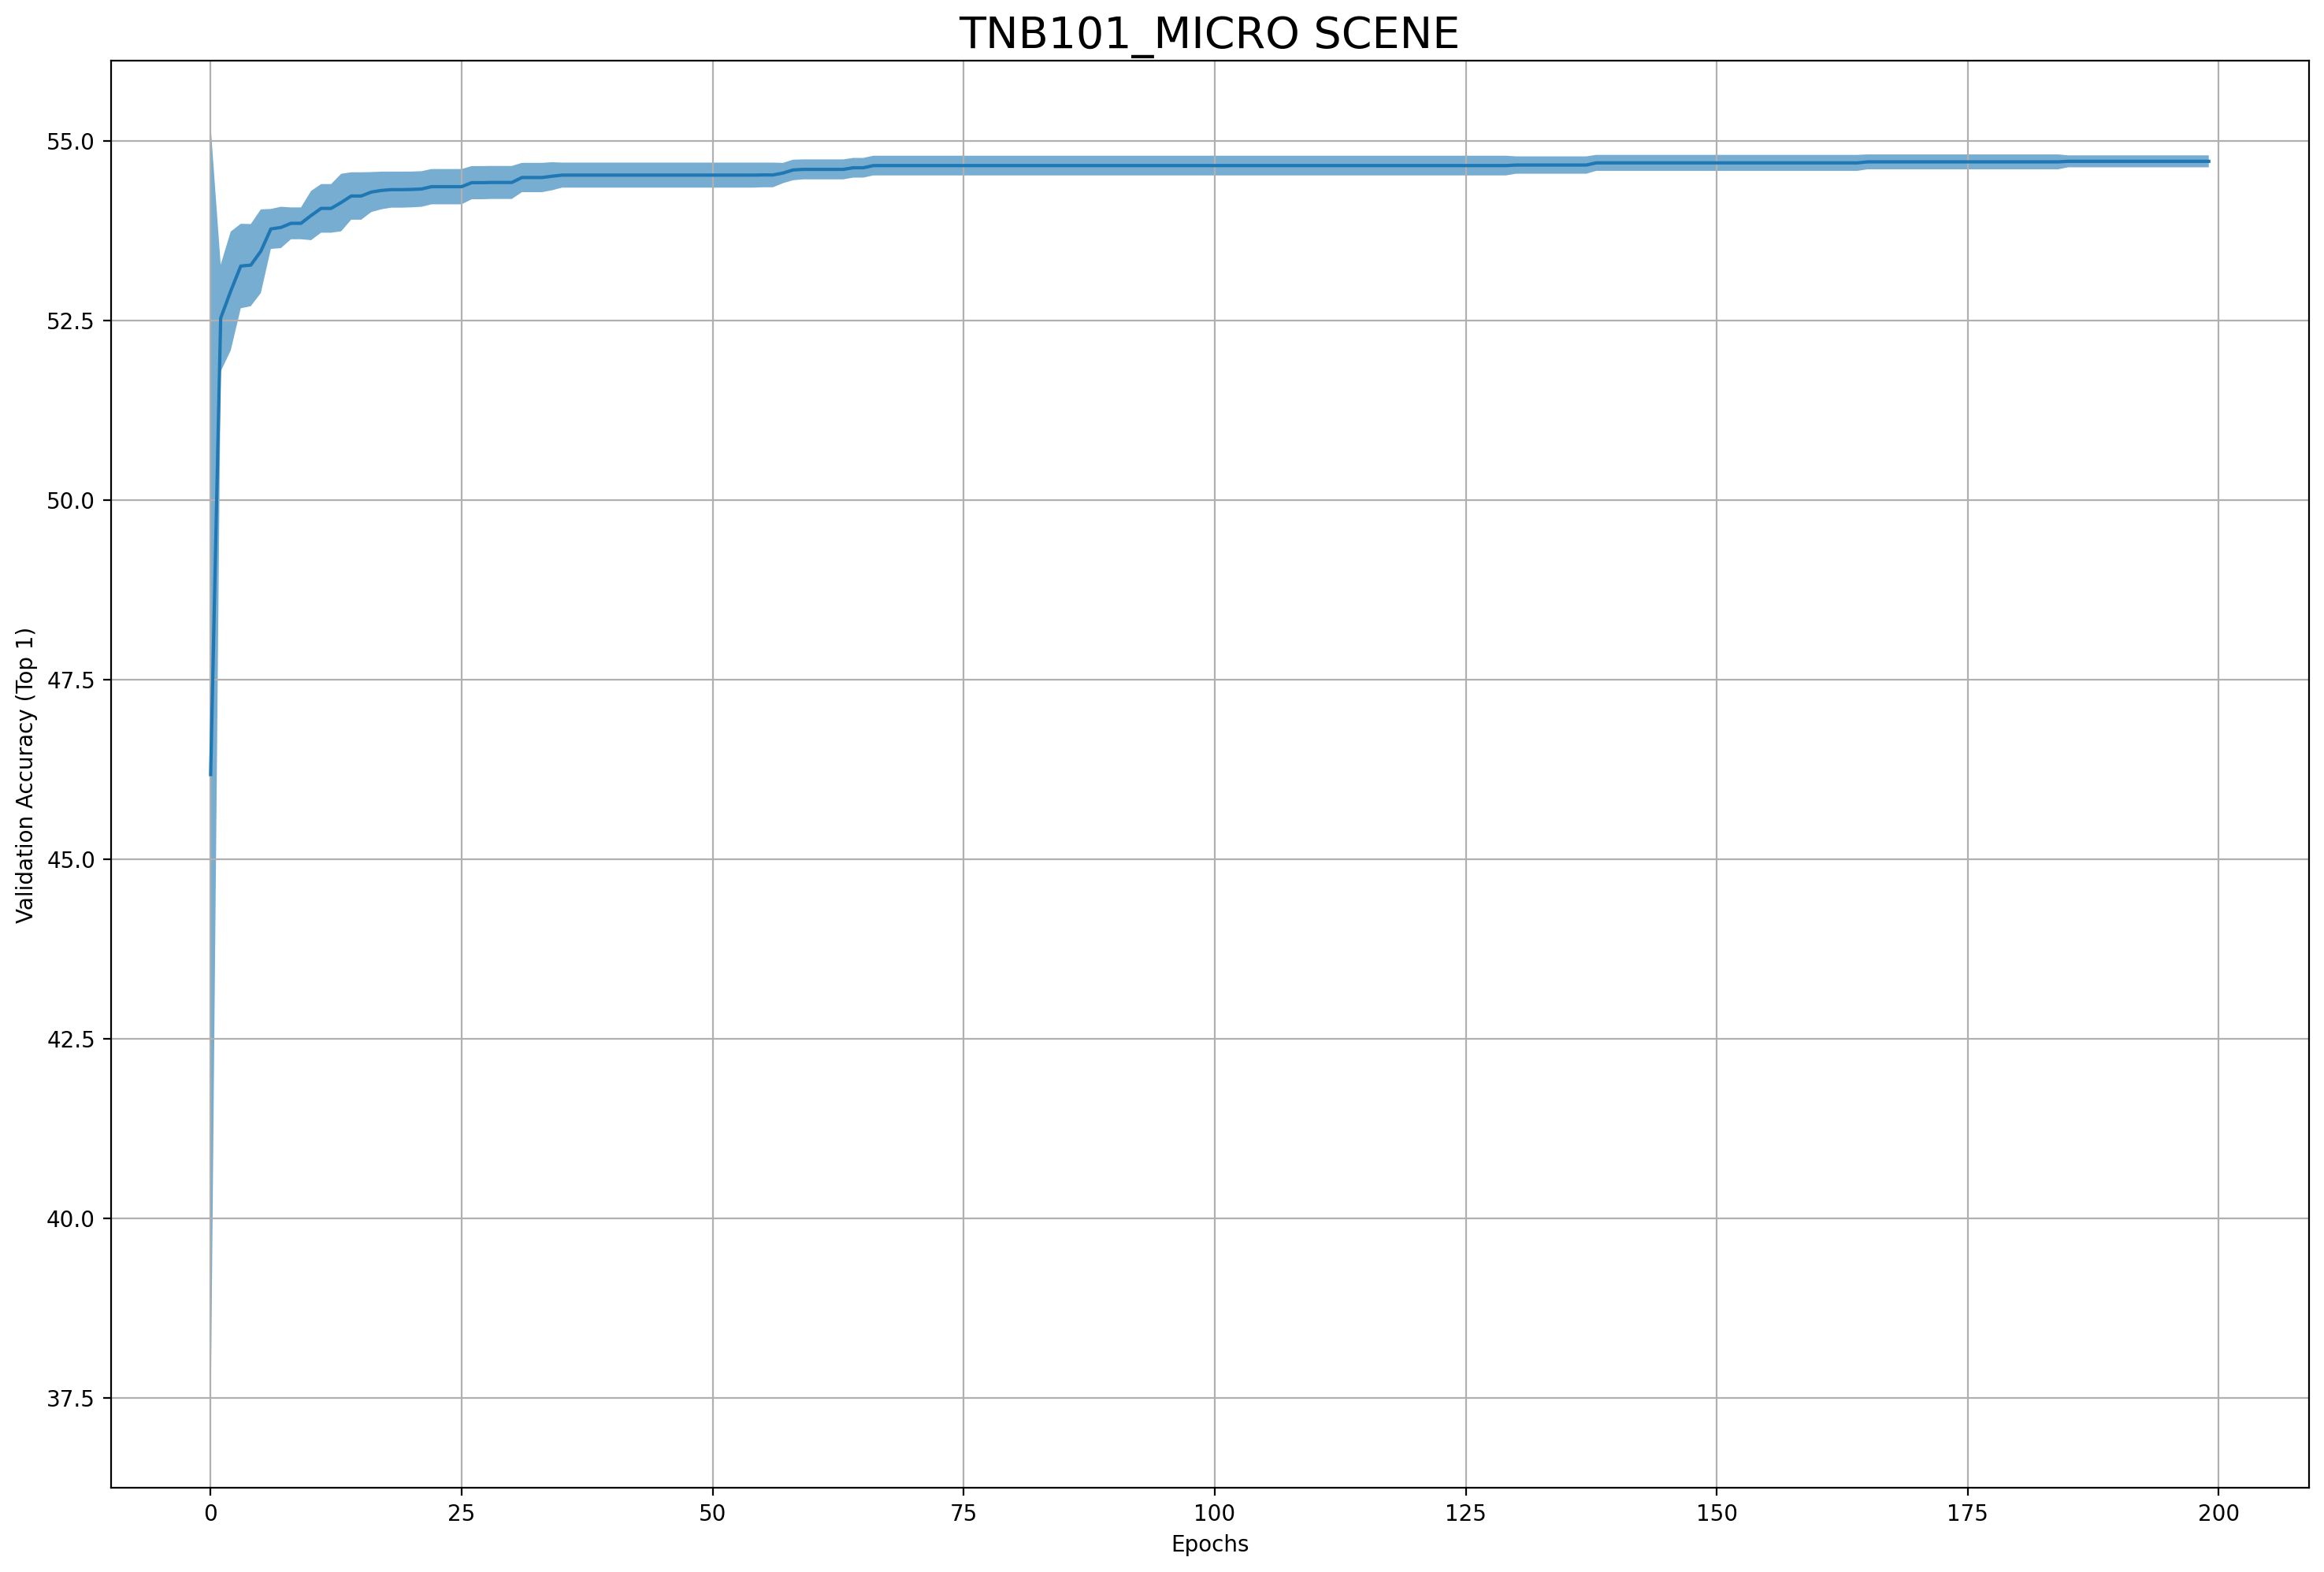

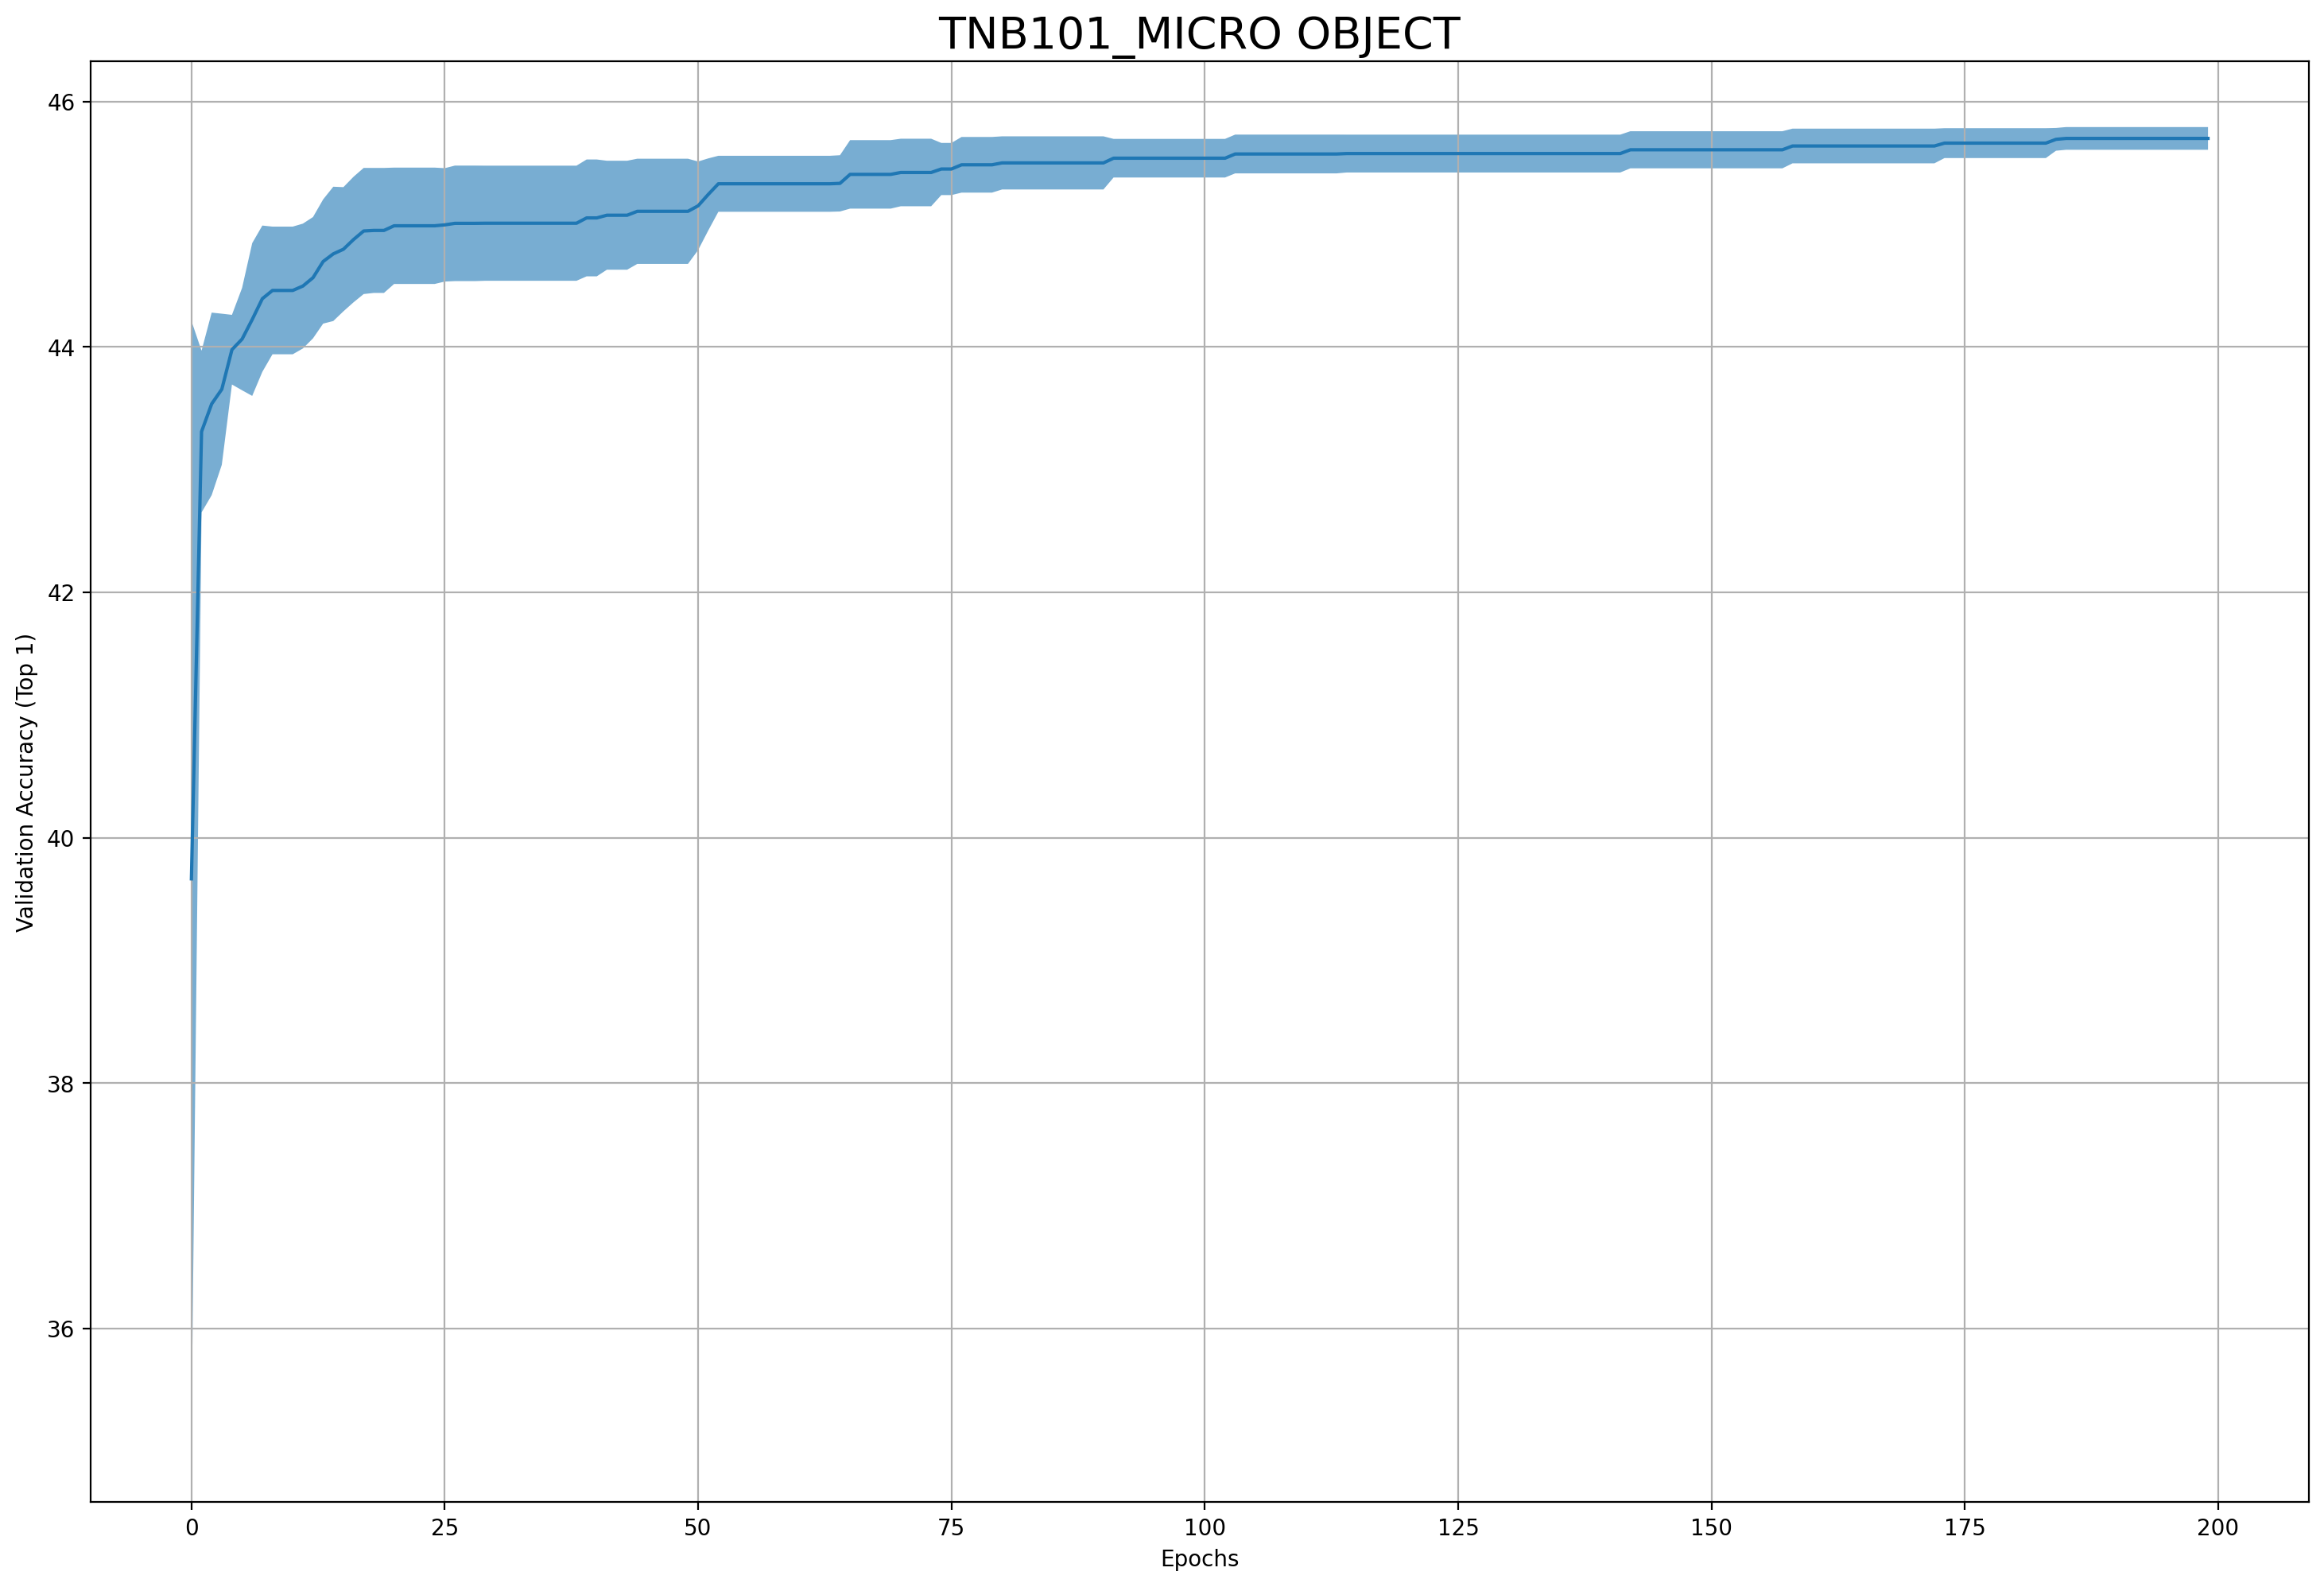

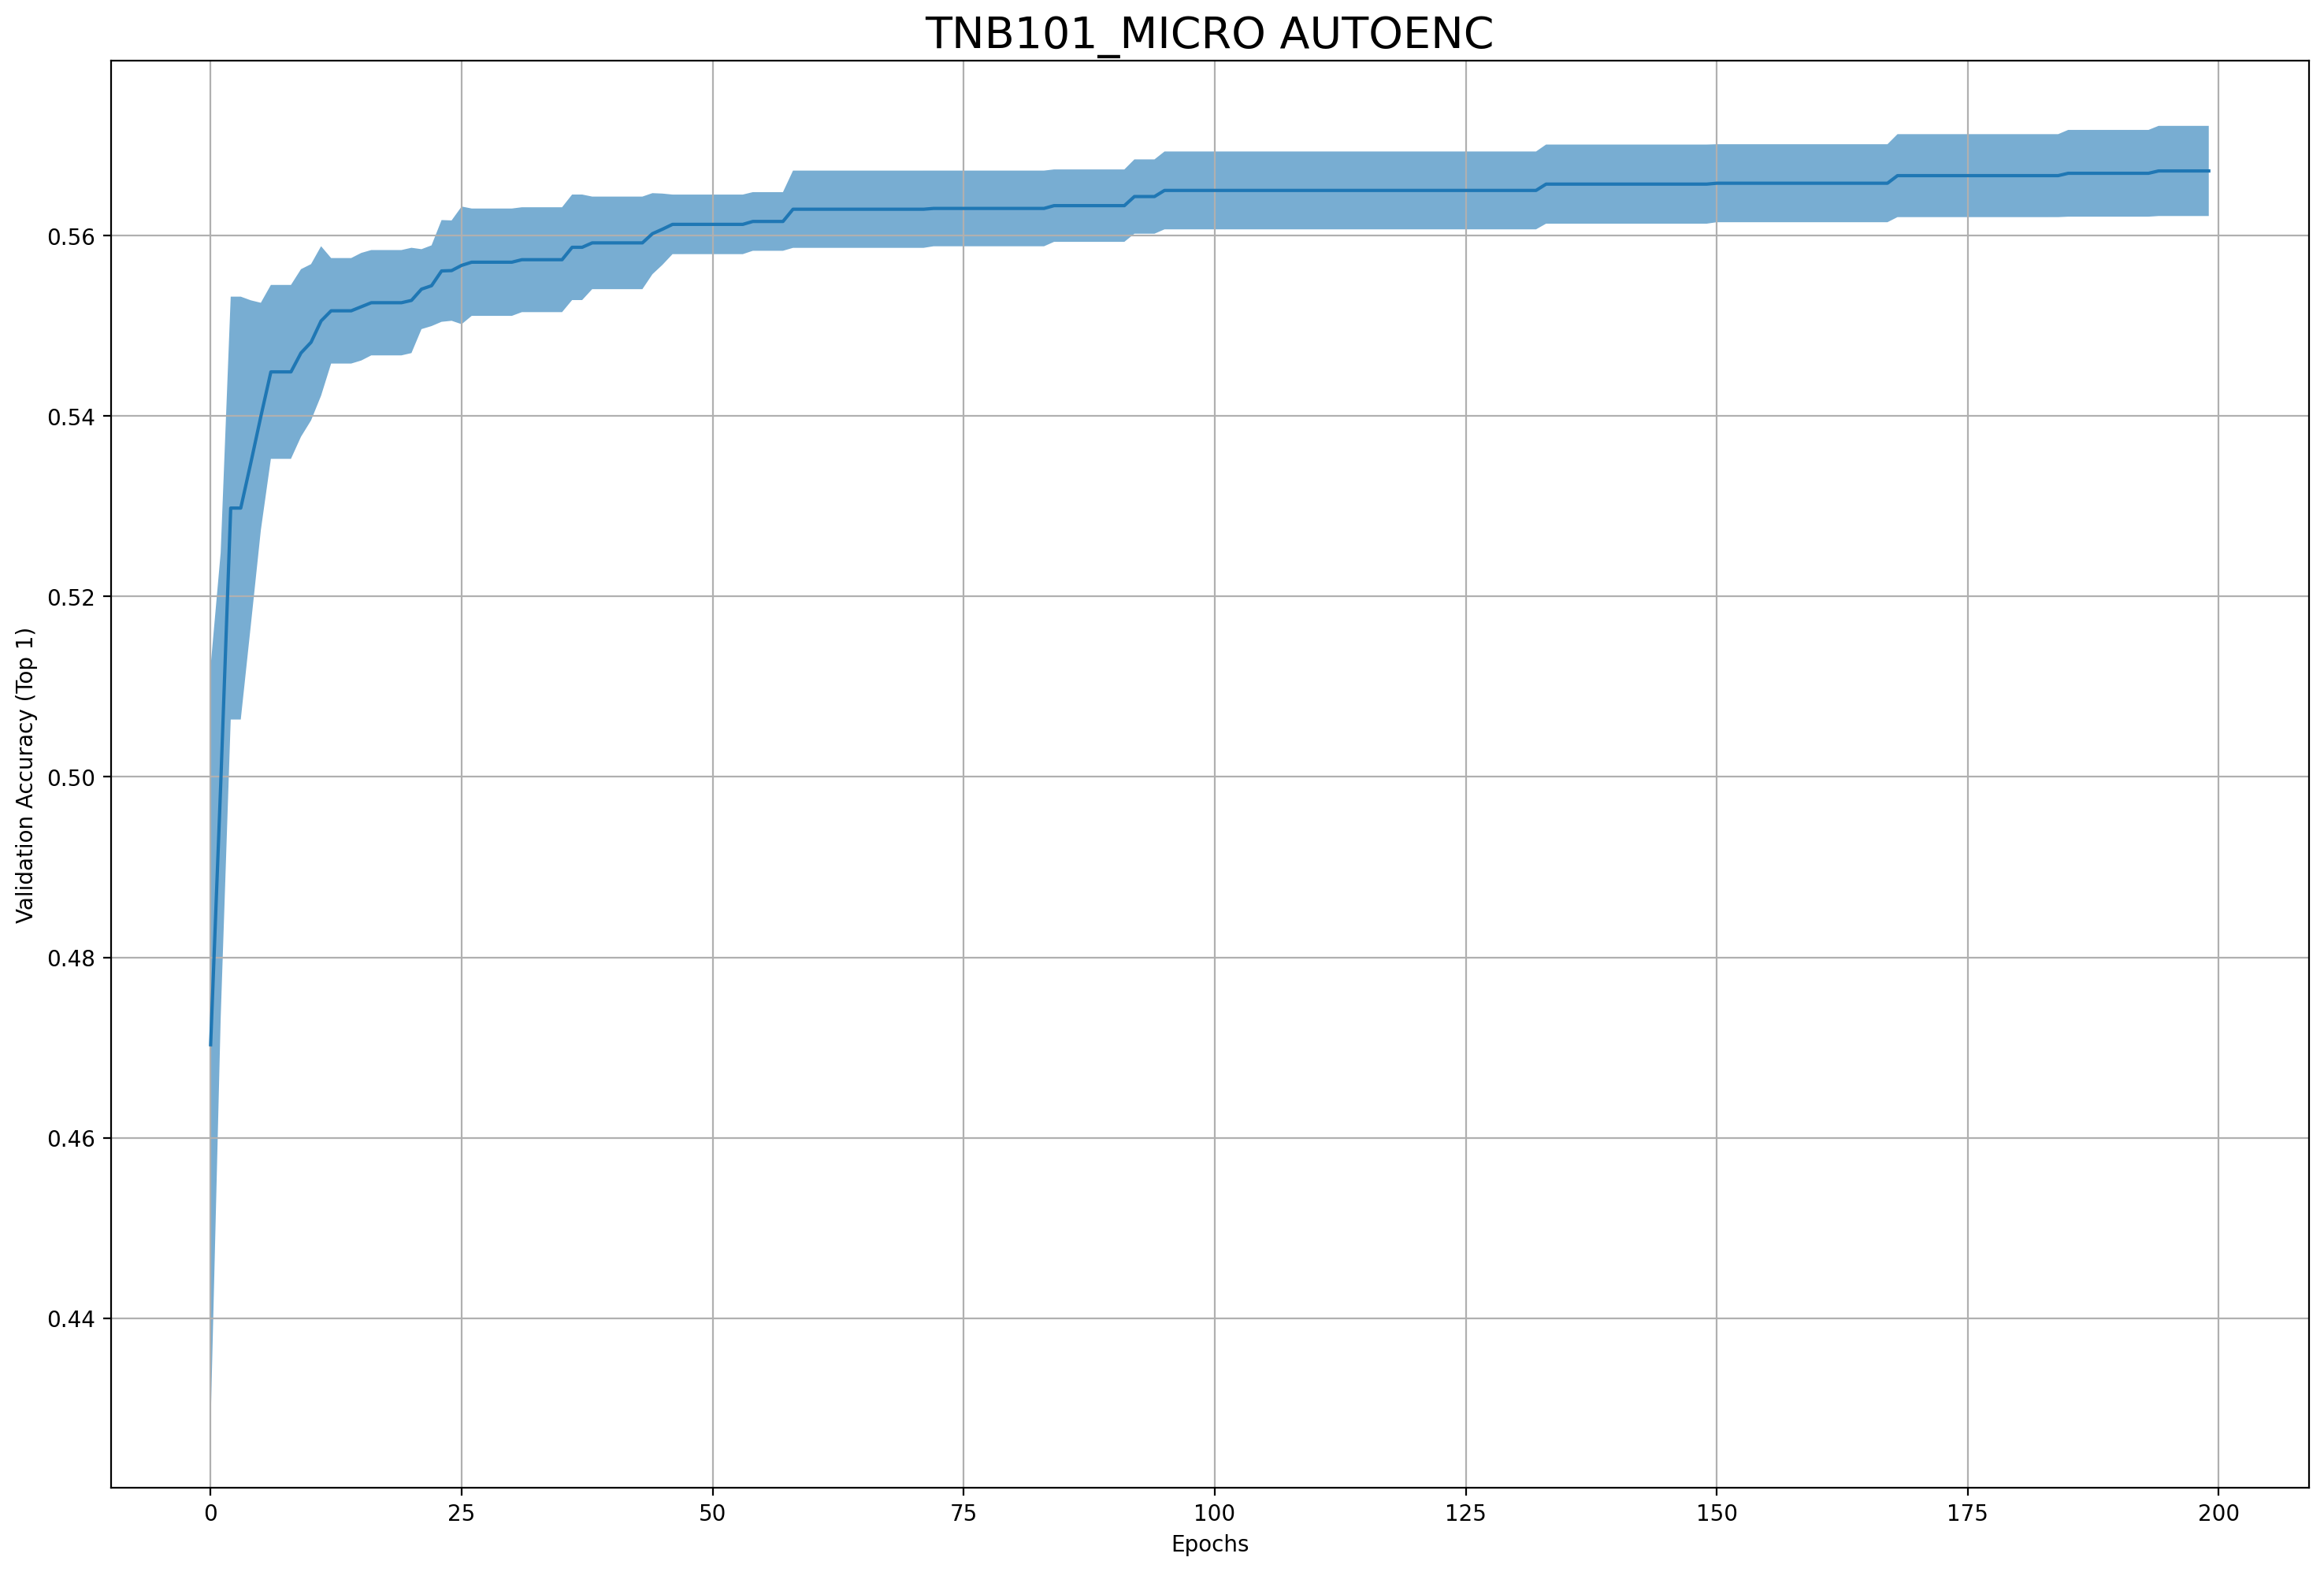

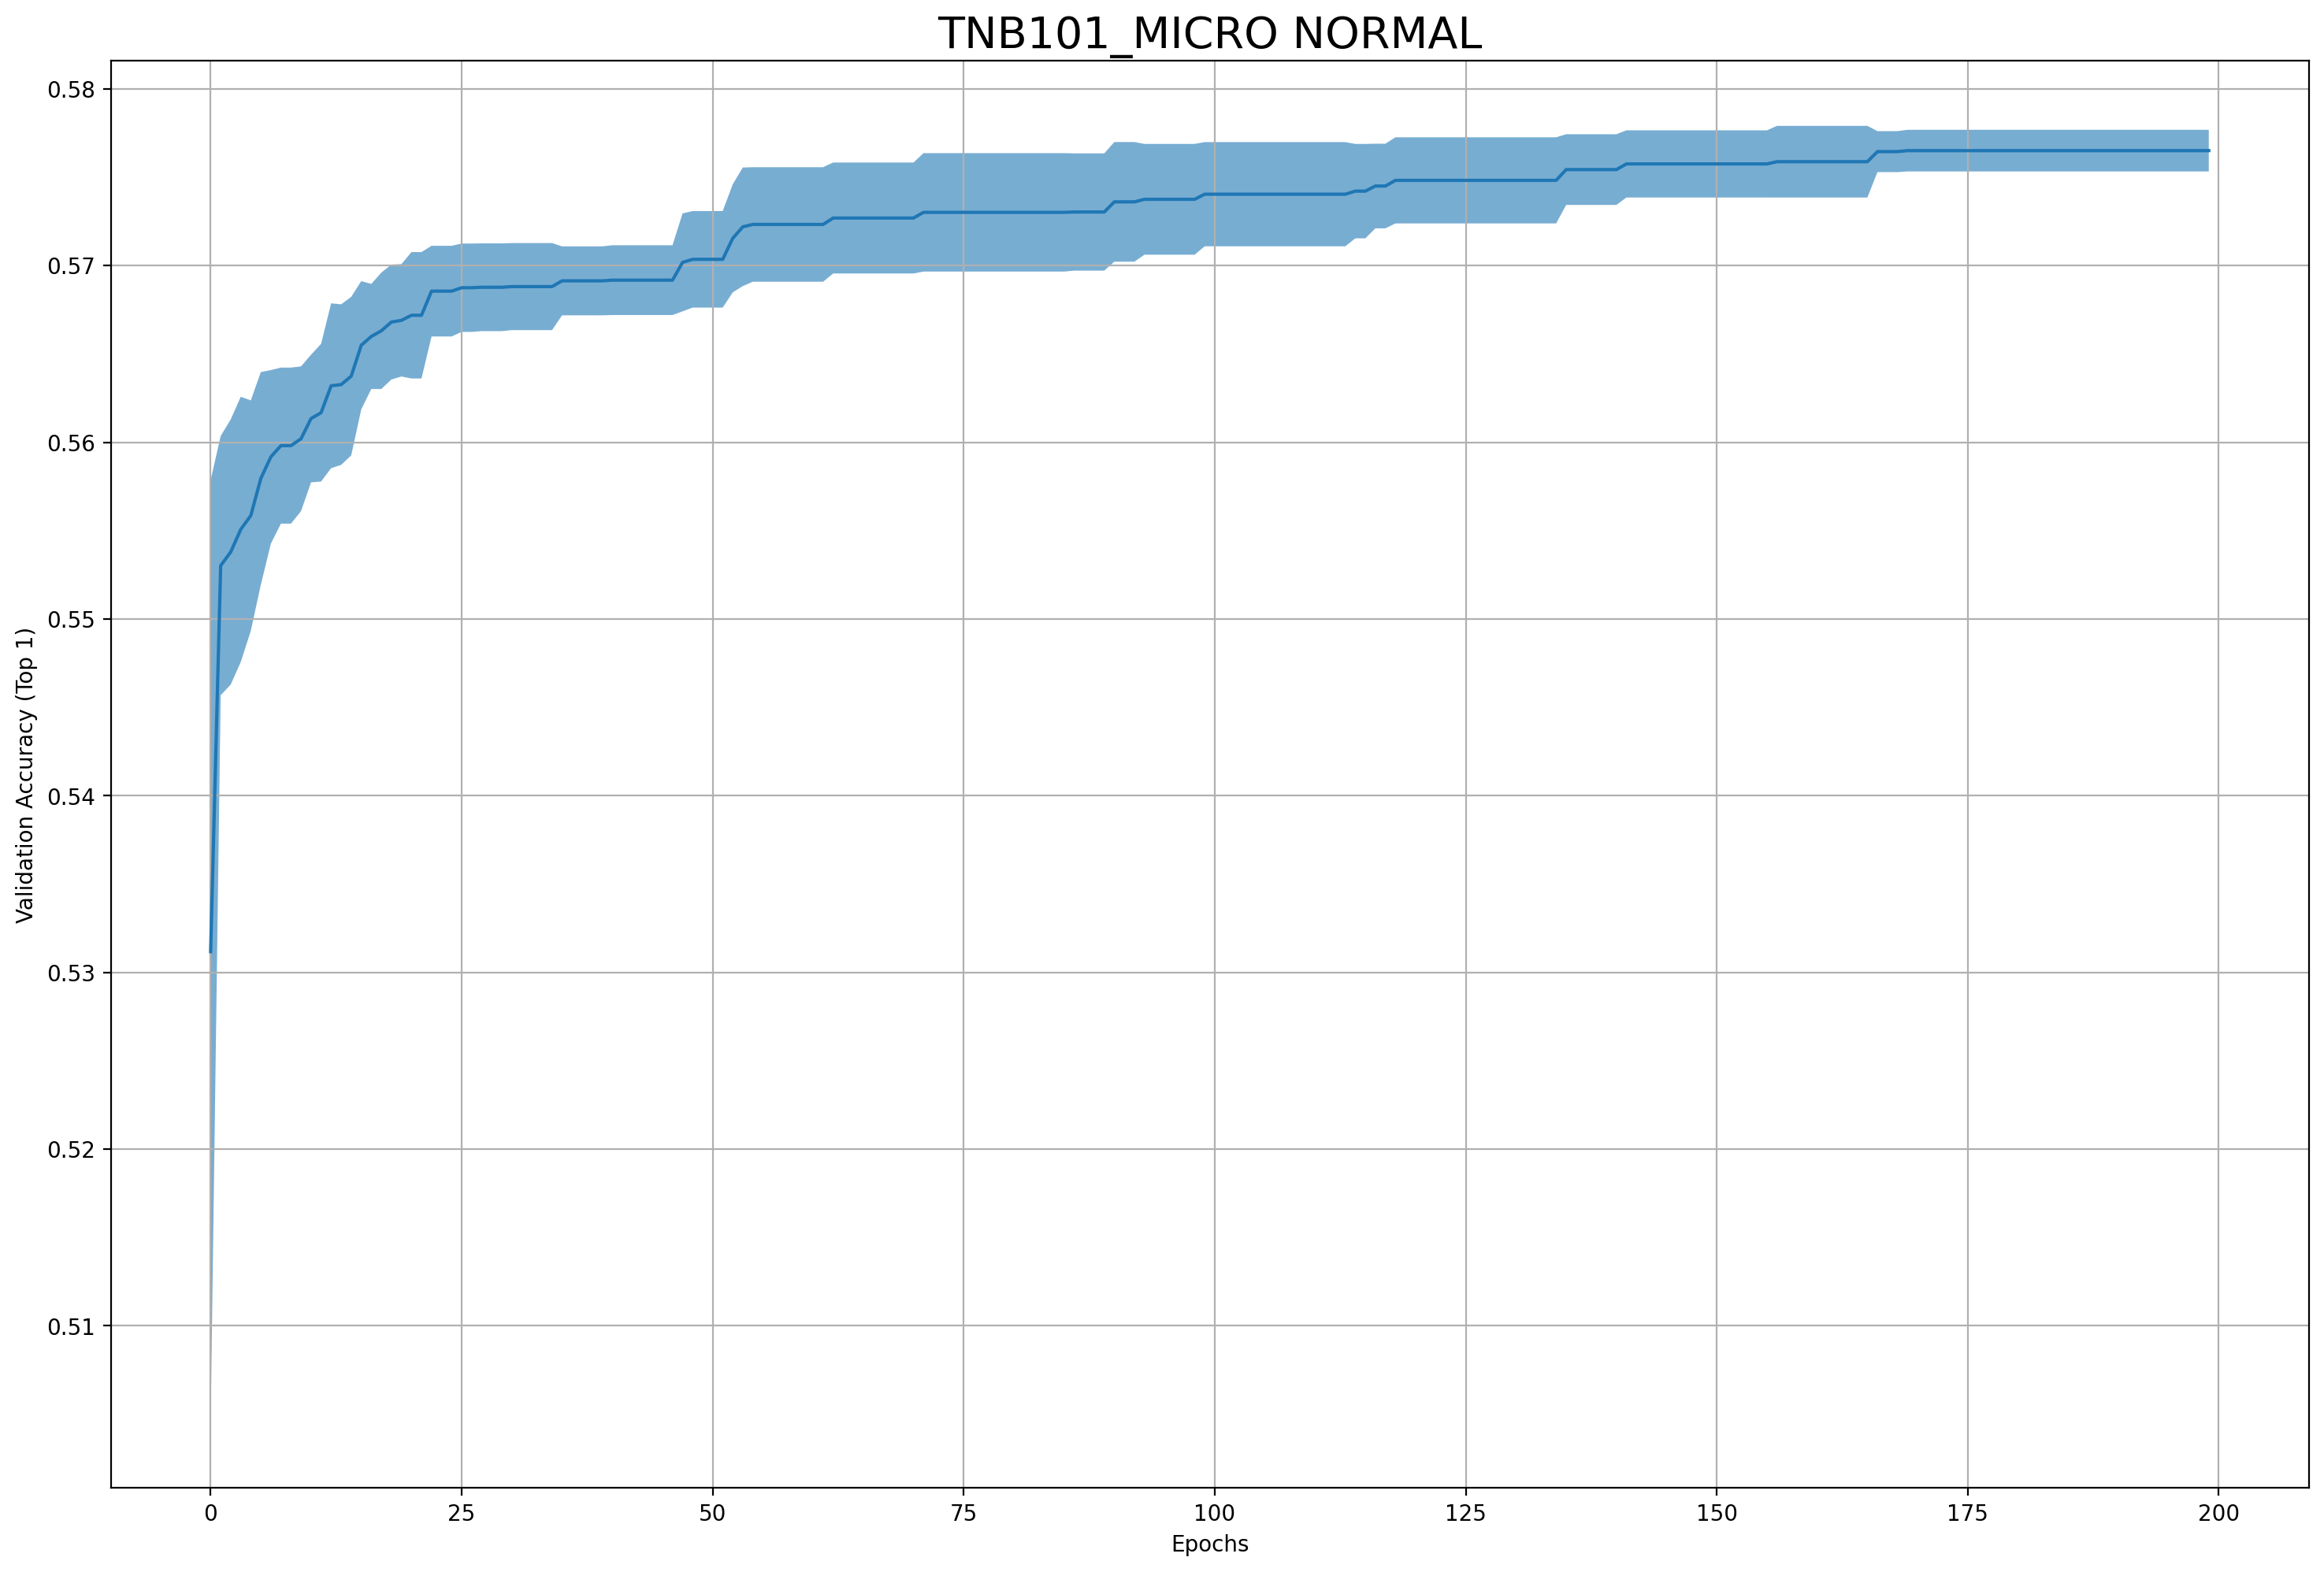

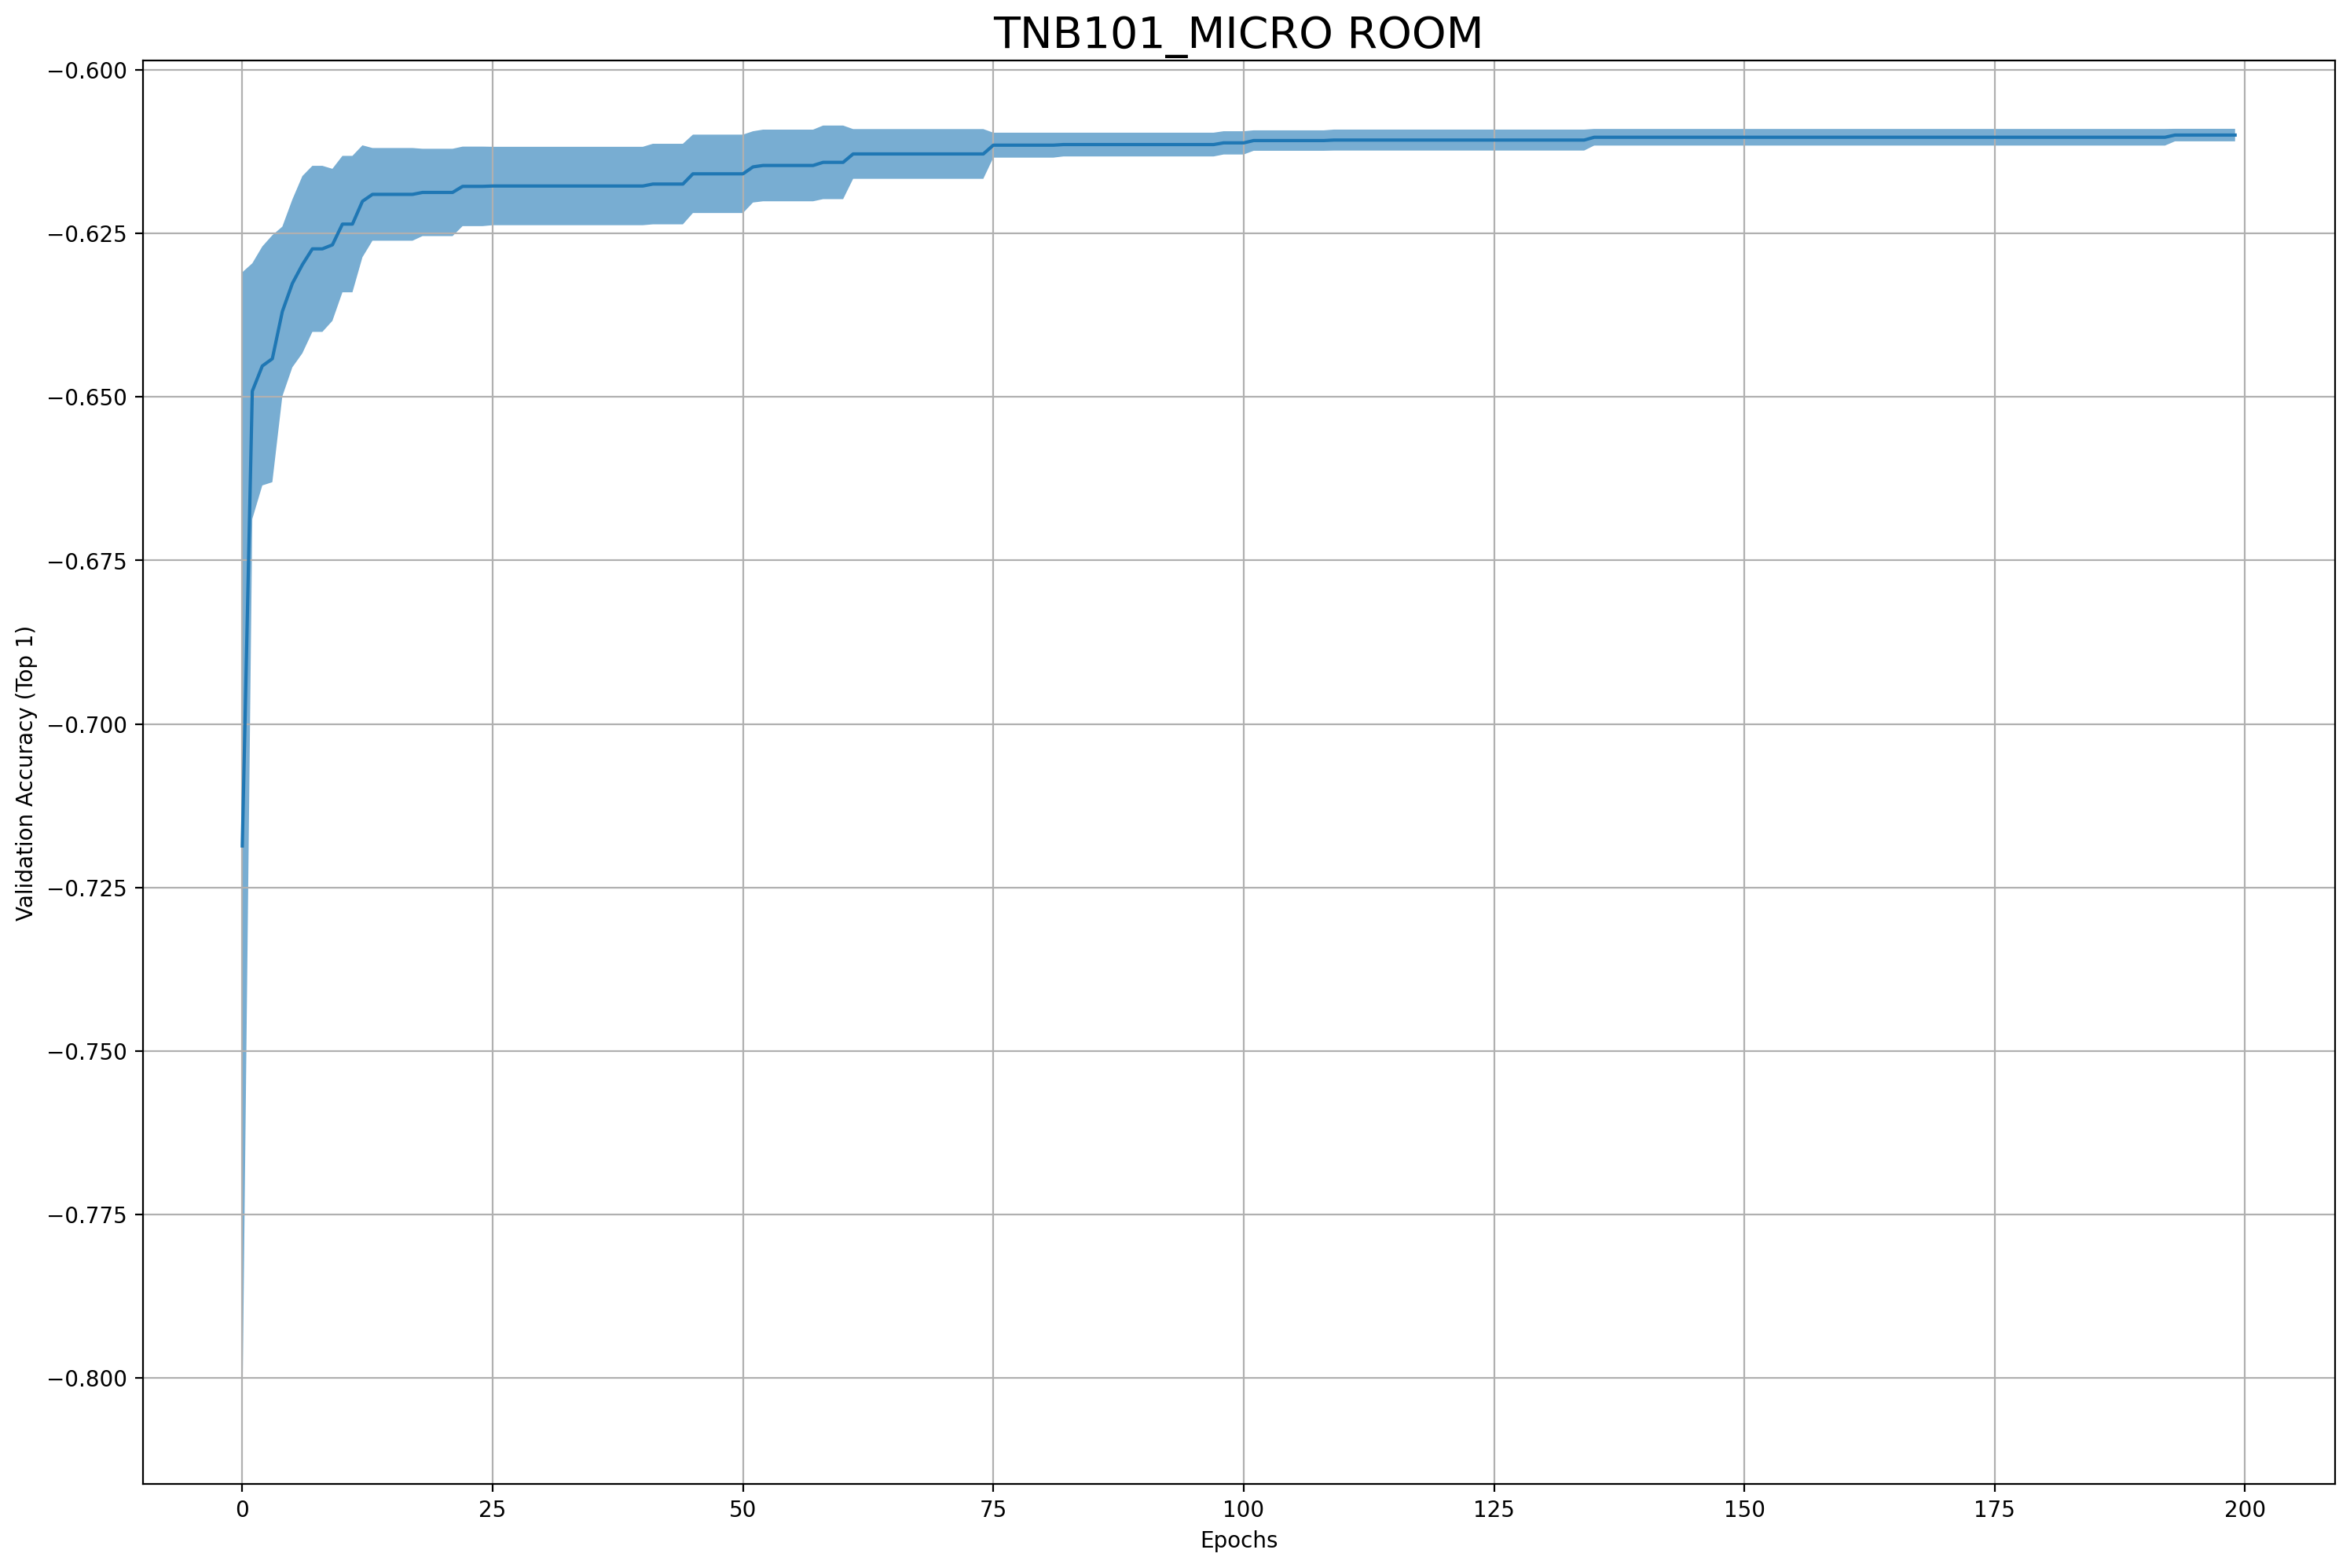

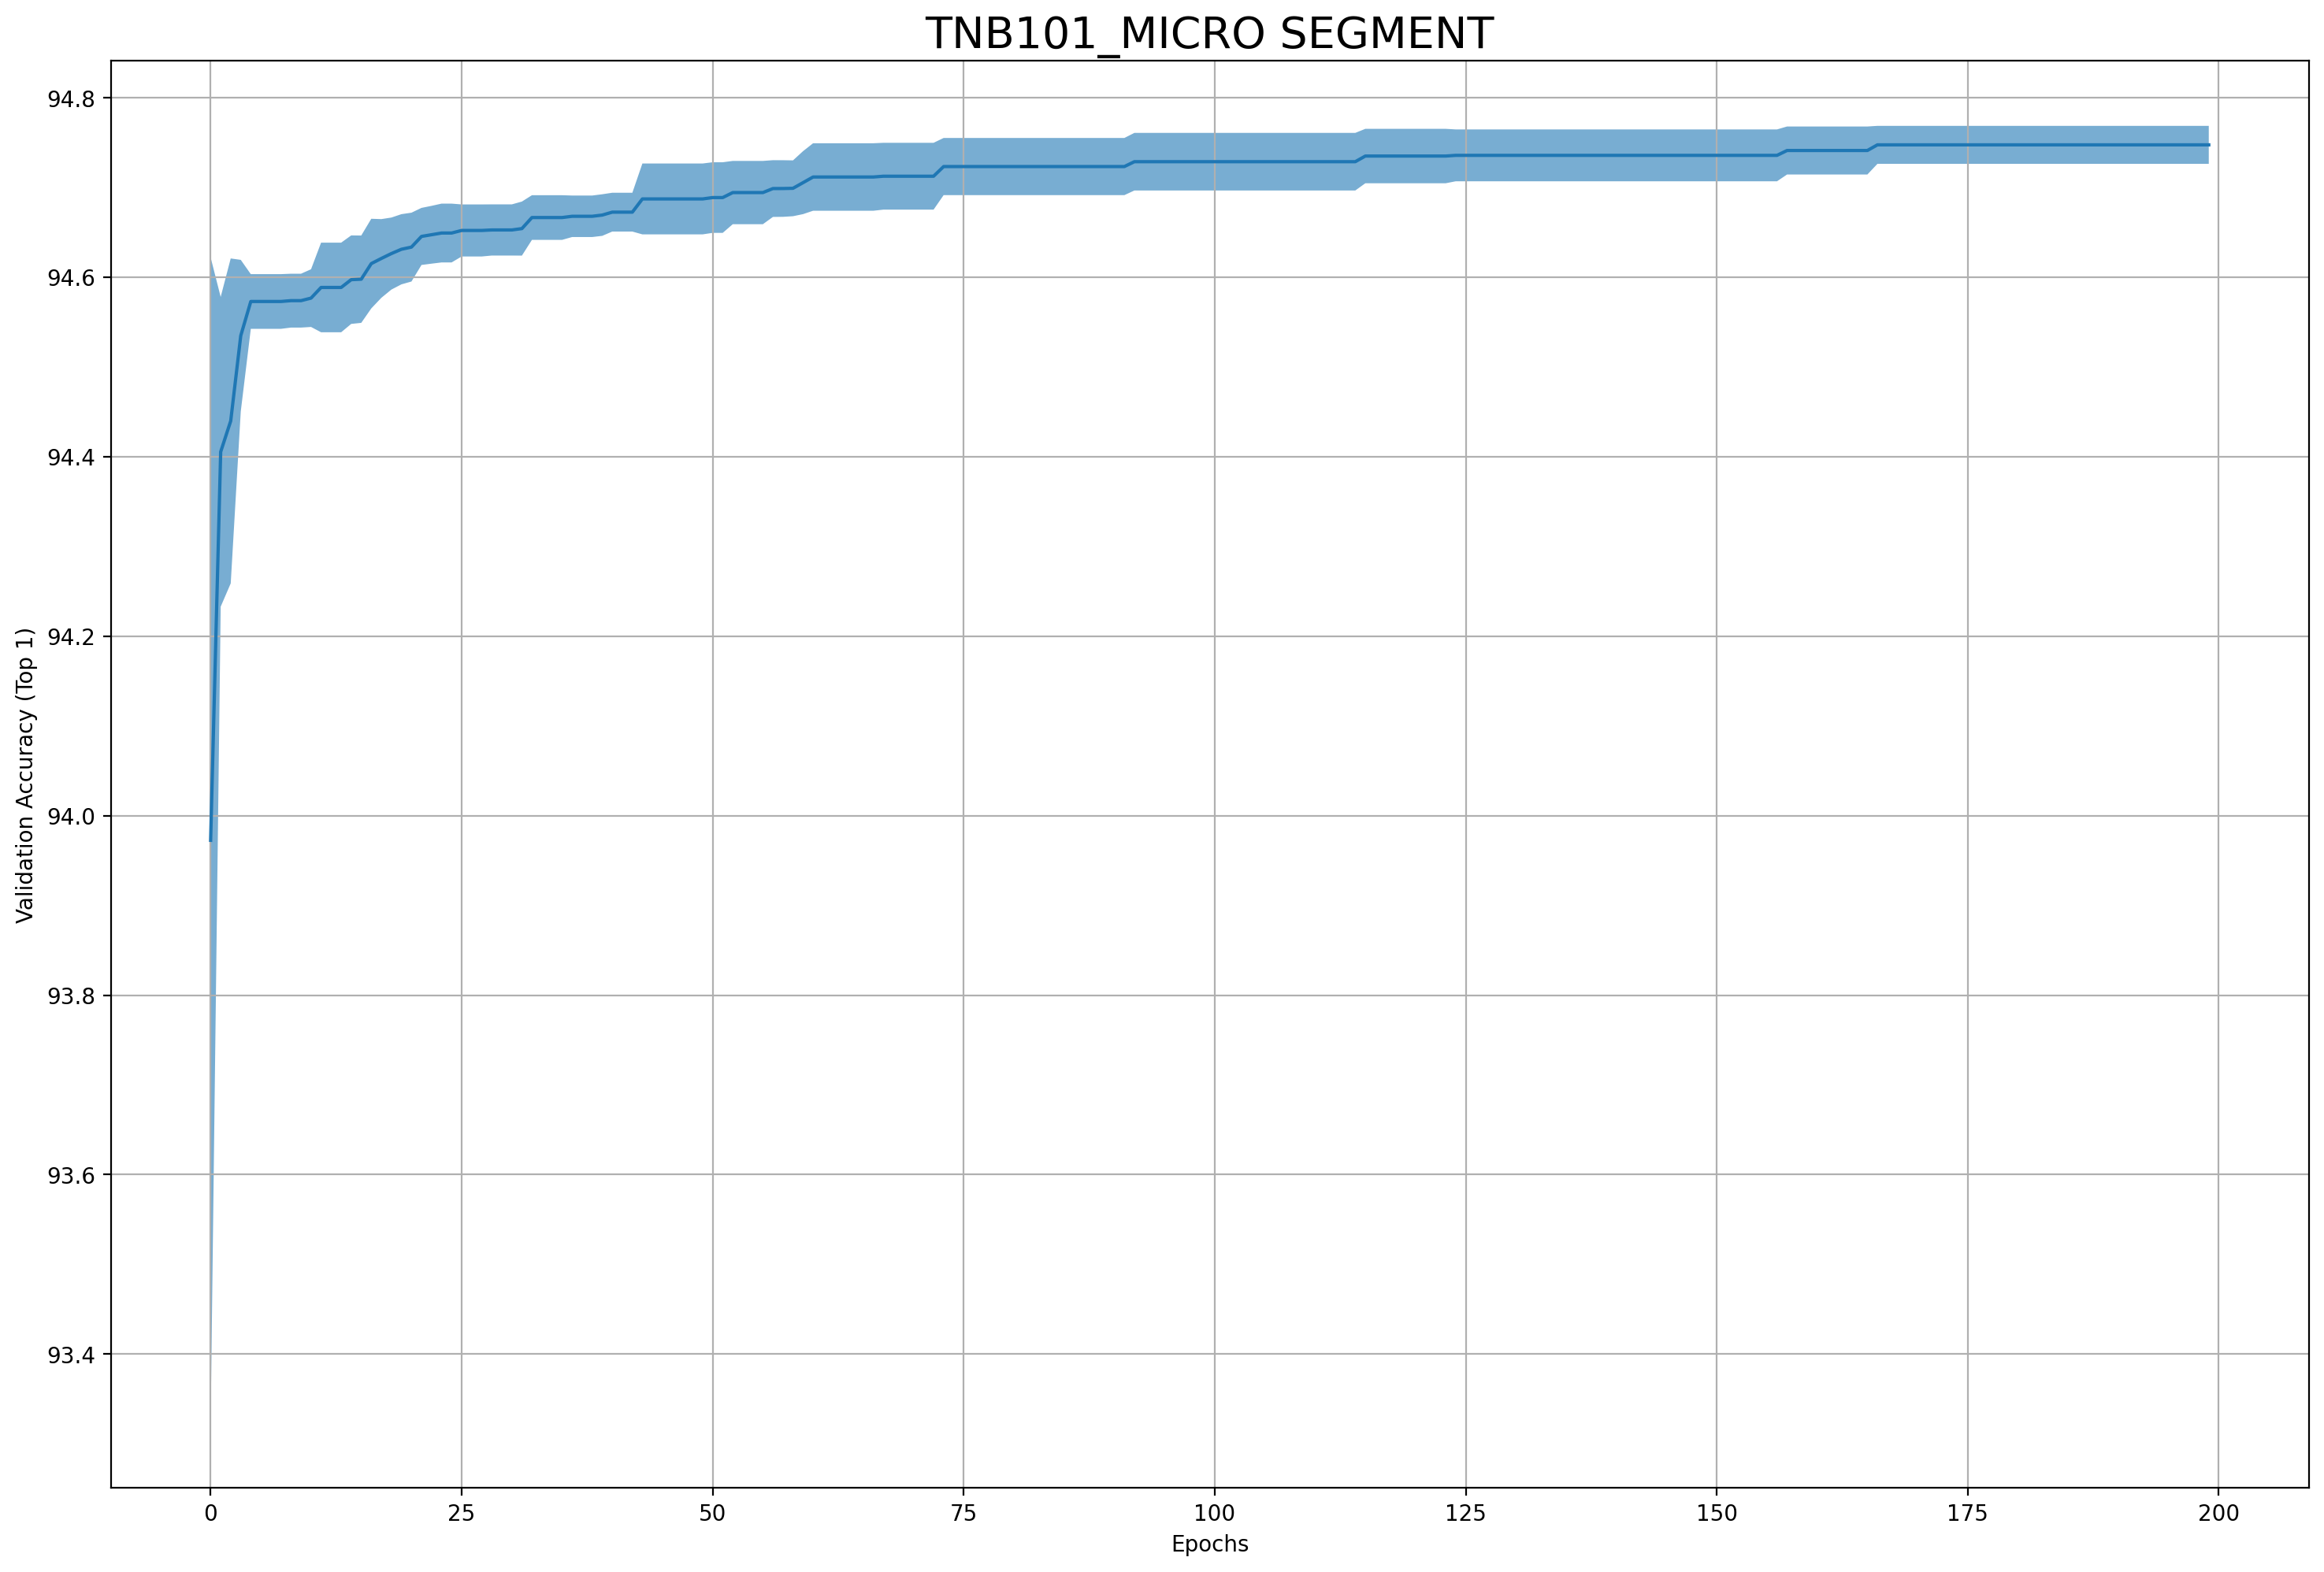

In [14]:
# plot_for_search_space(df, 'nasbench201')
plot_for_search_space(df, 'transbench101_micro')

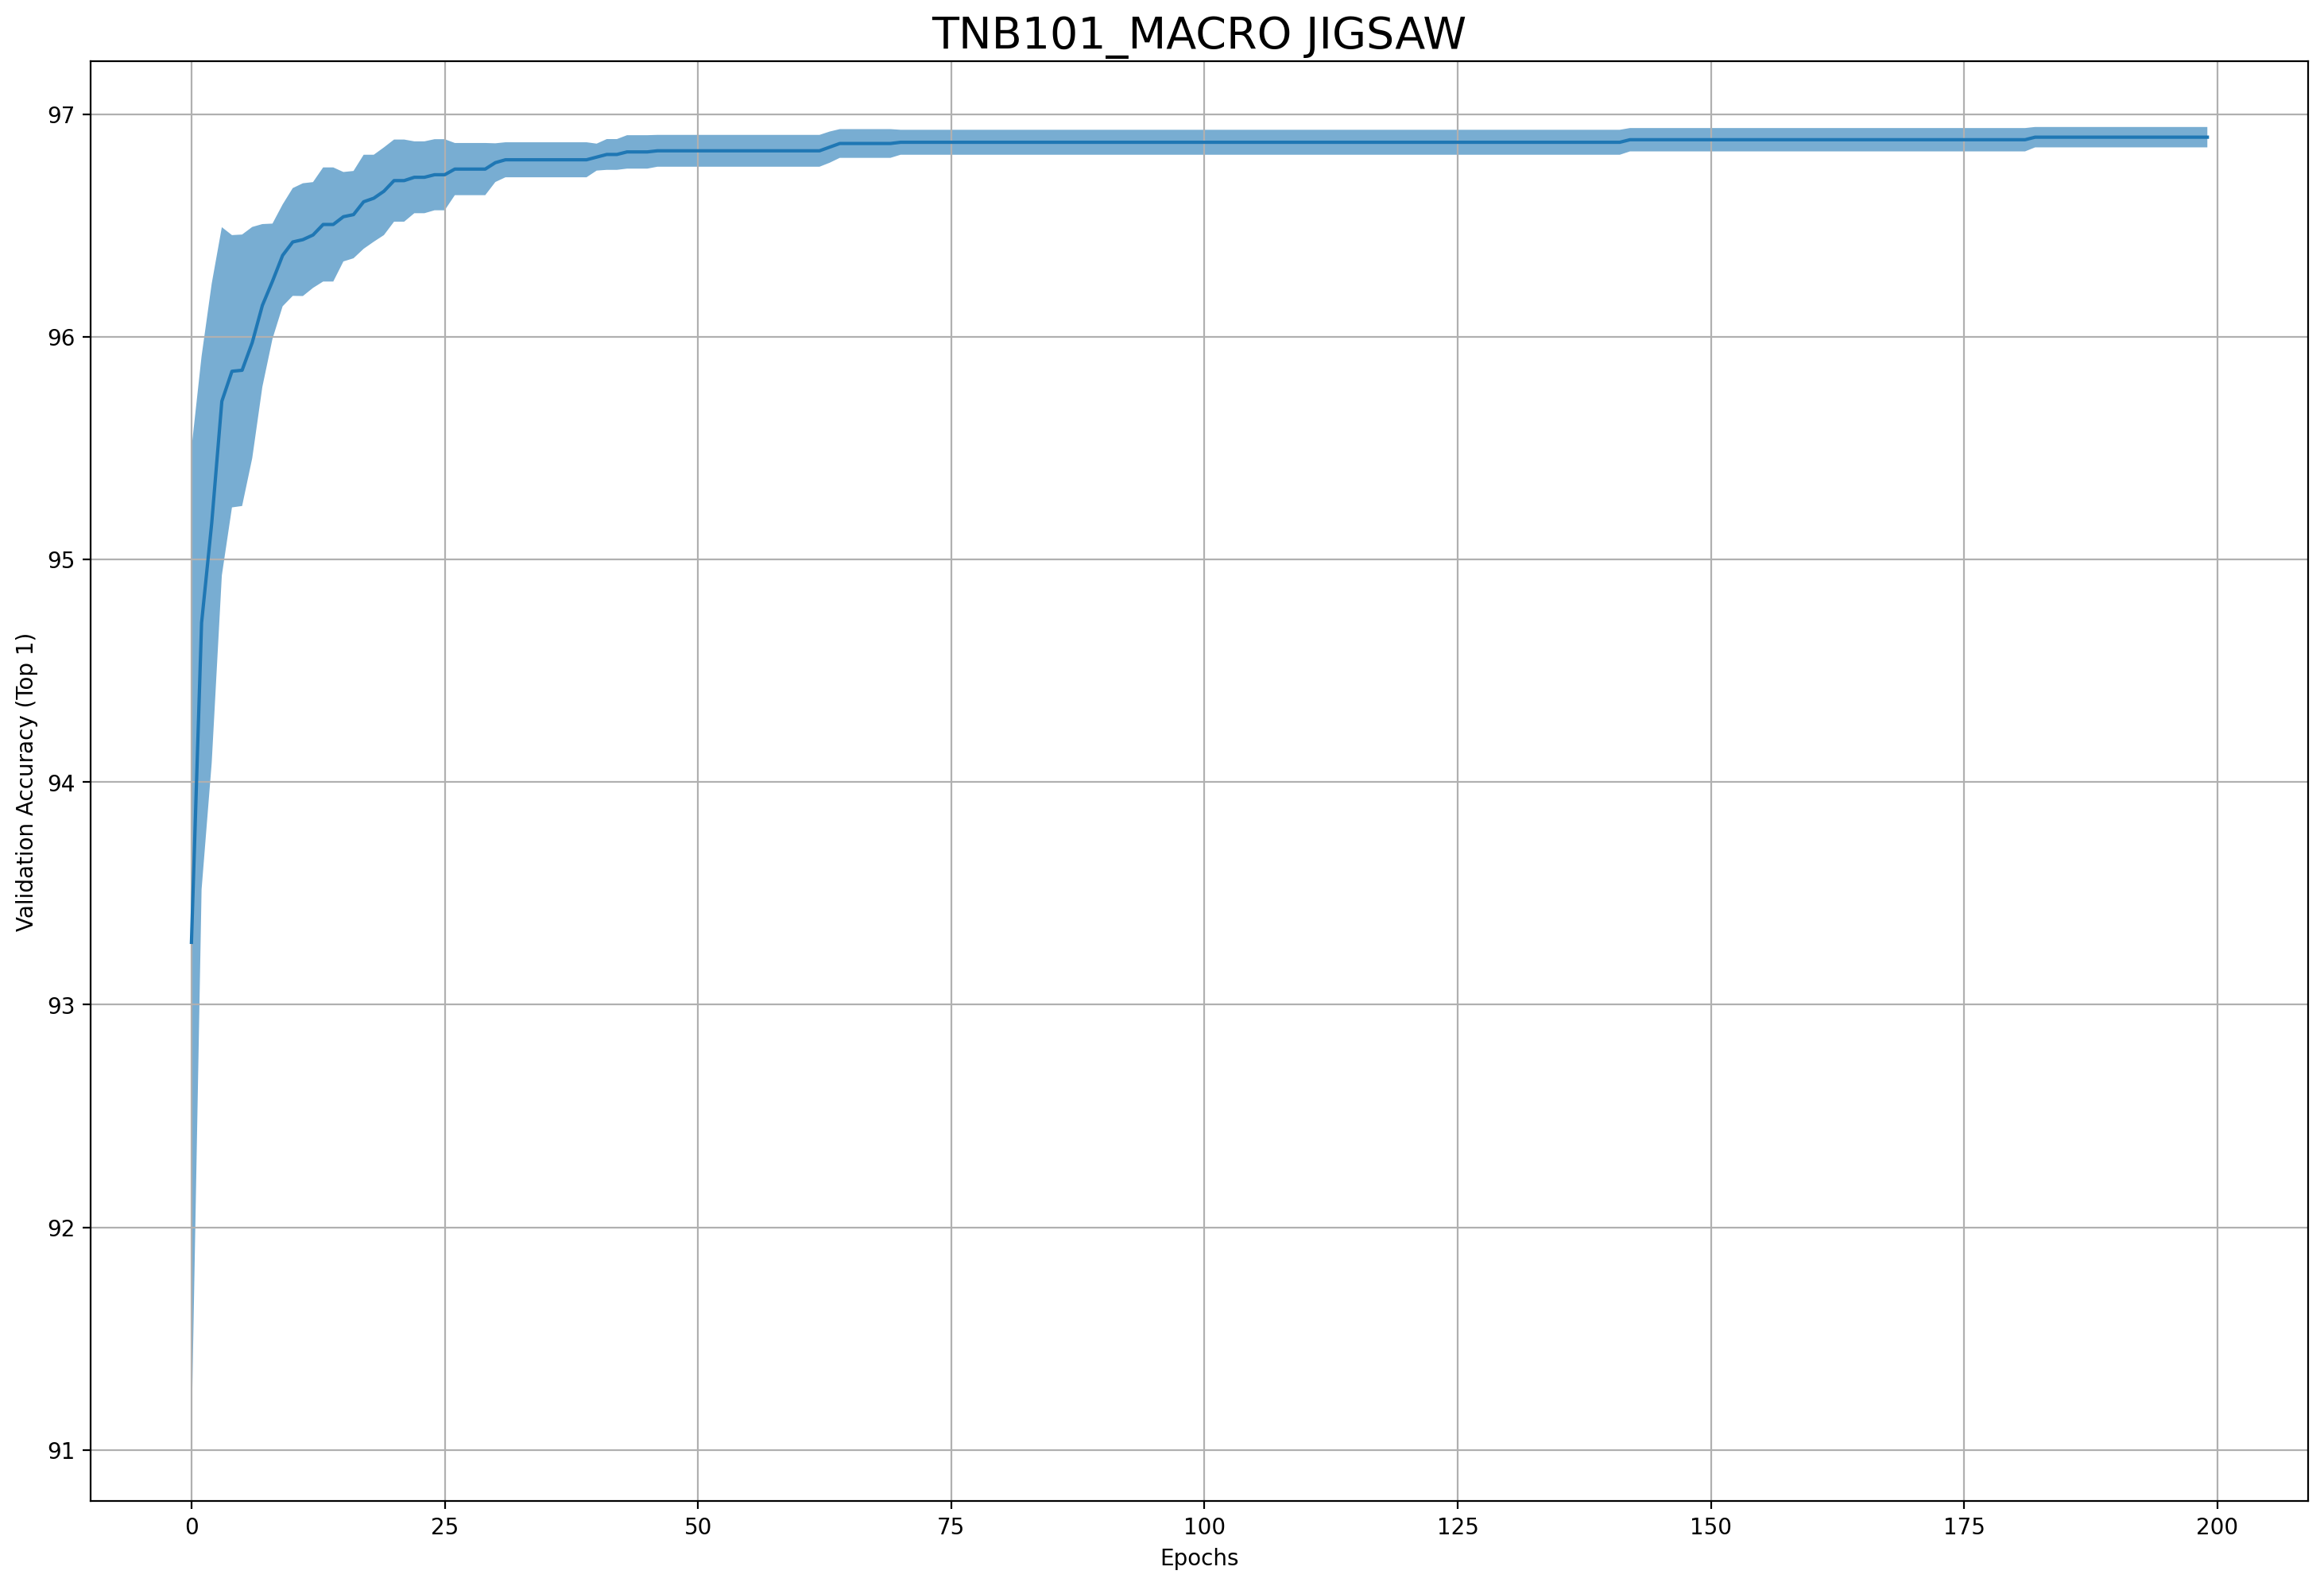

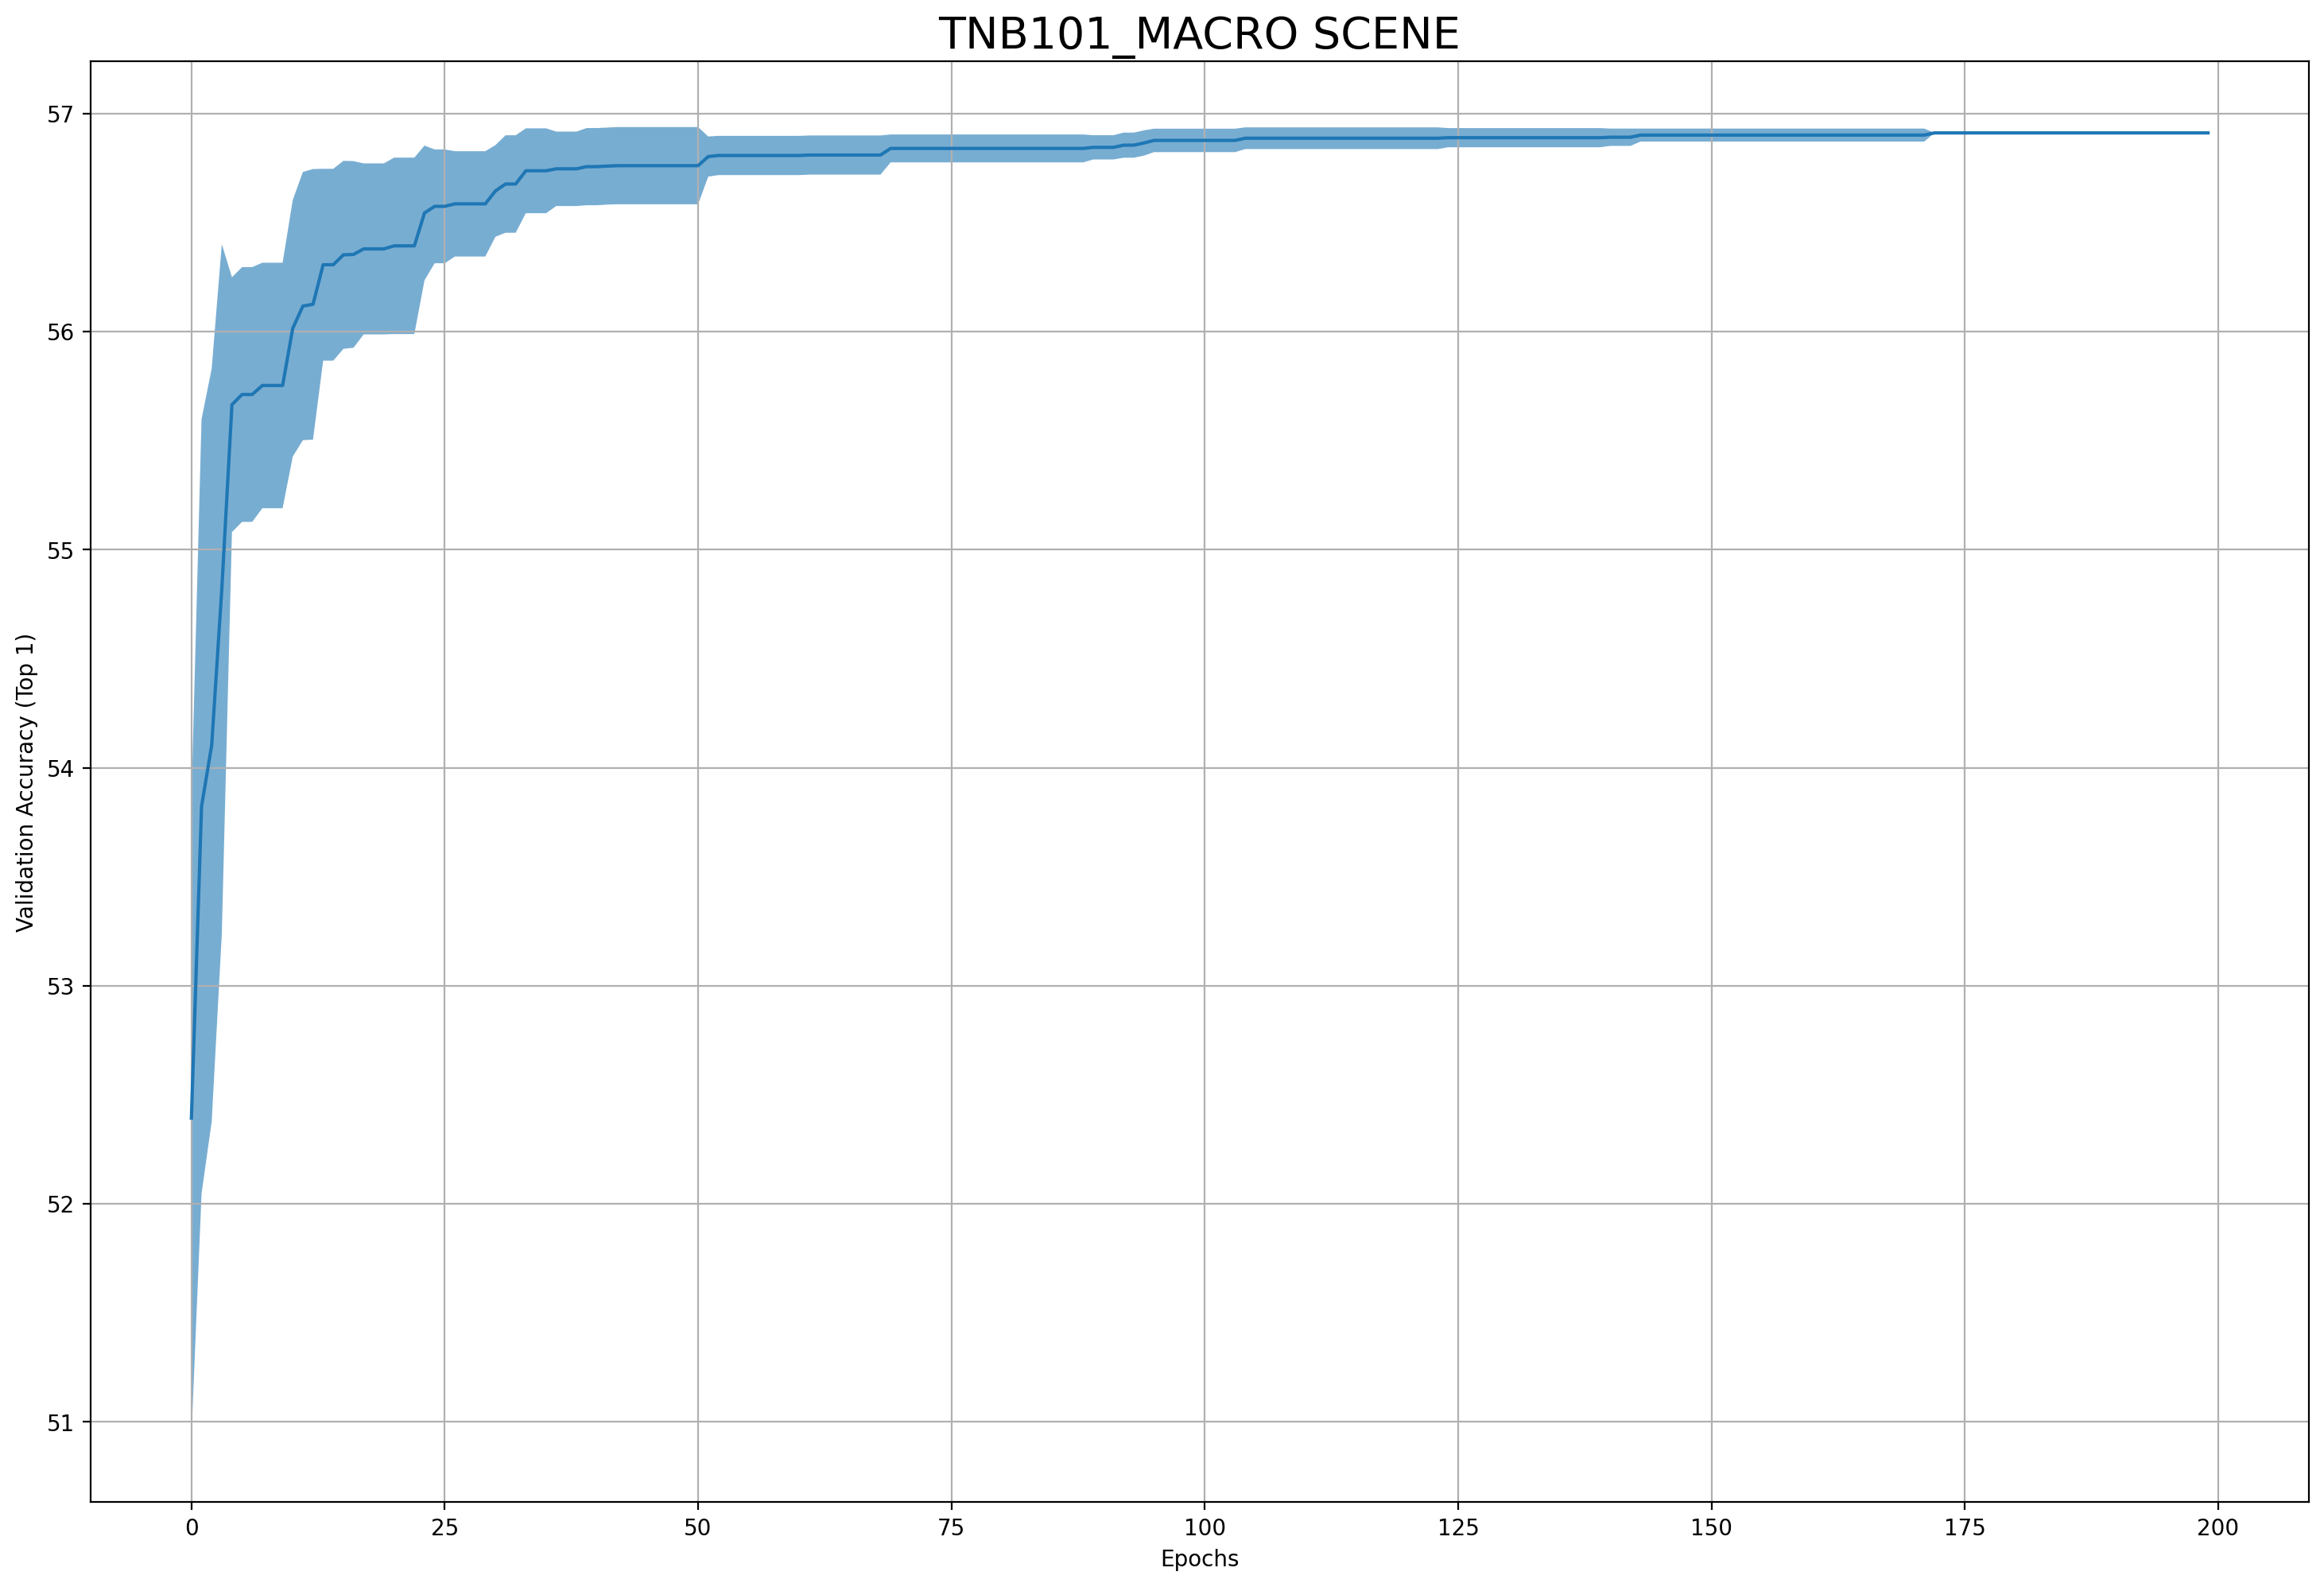

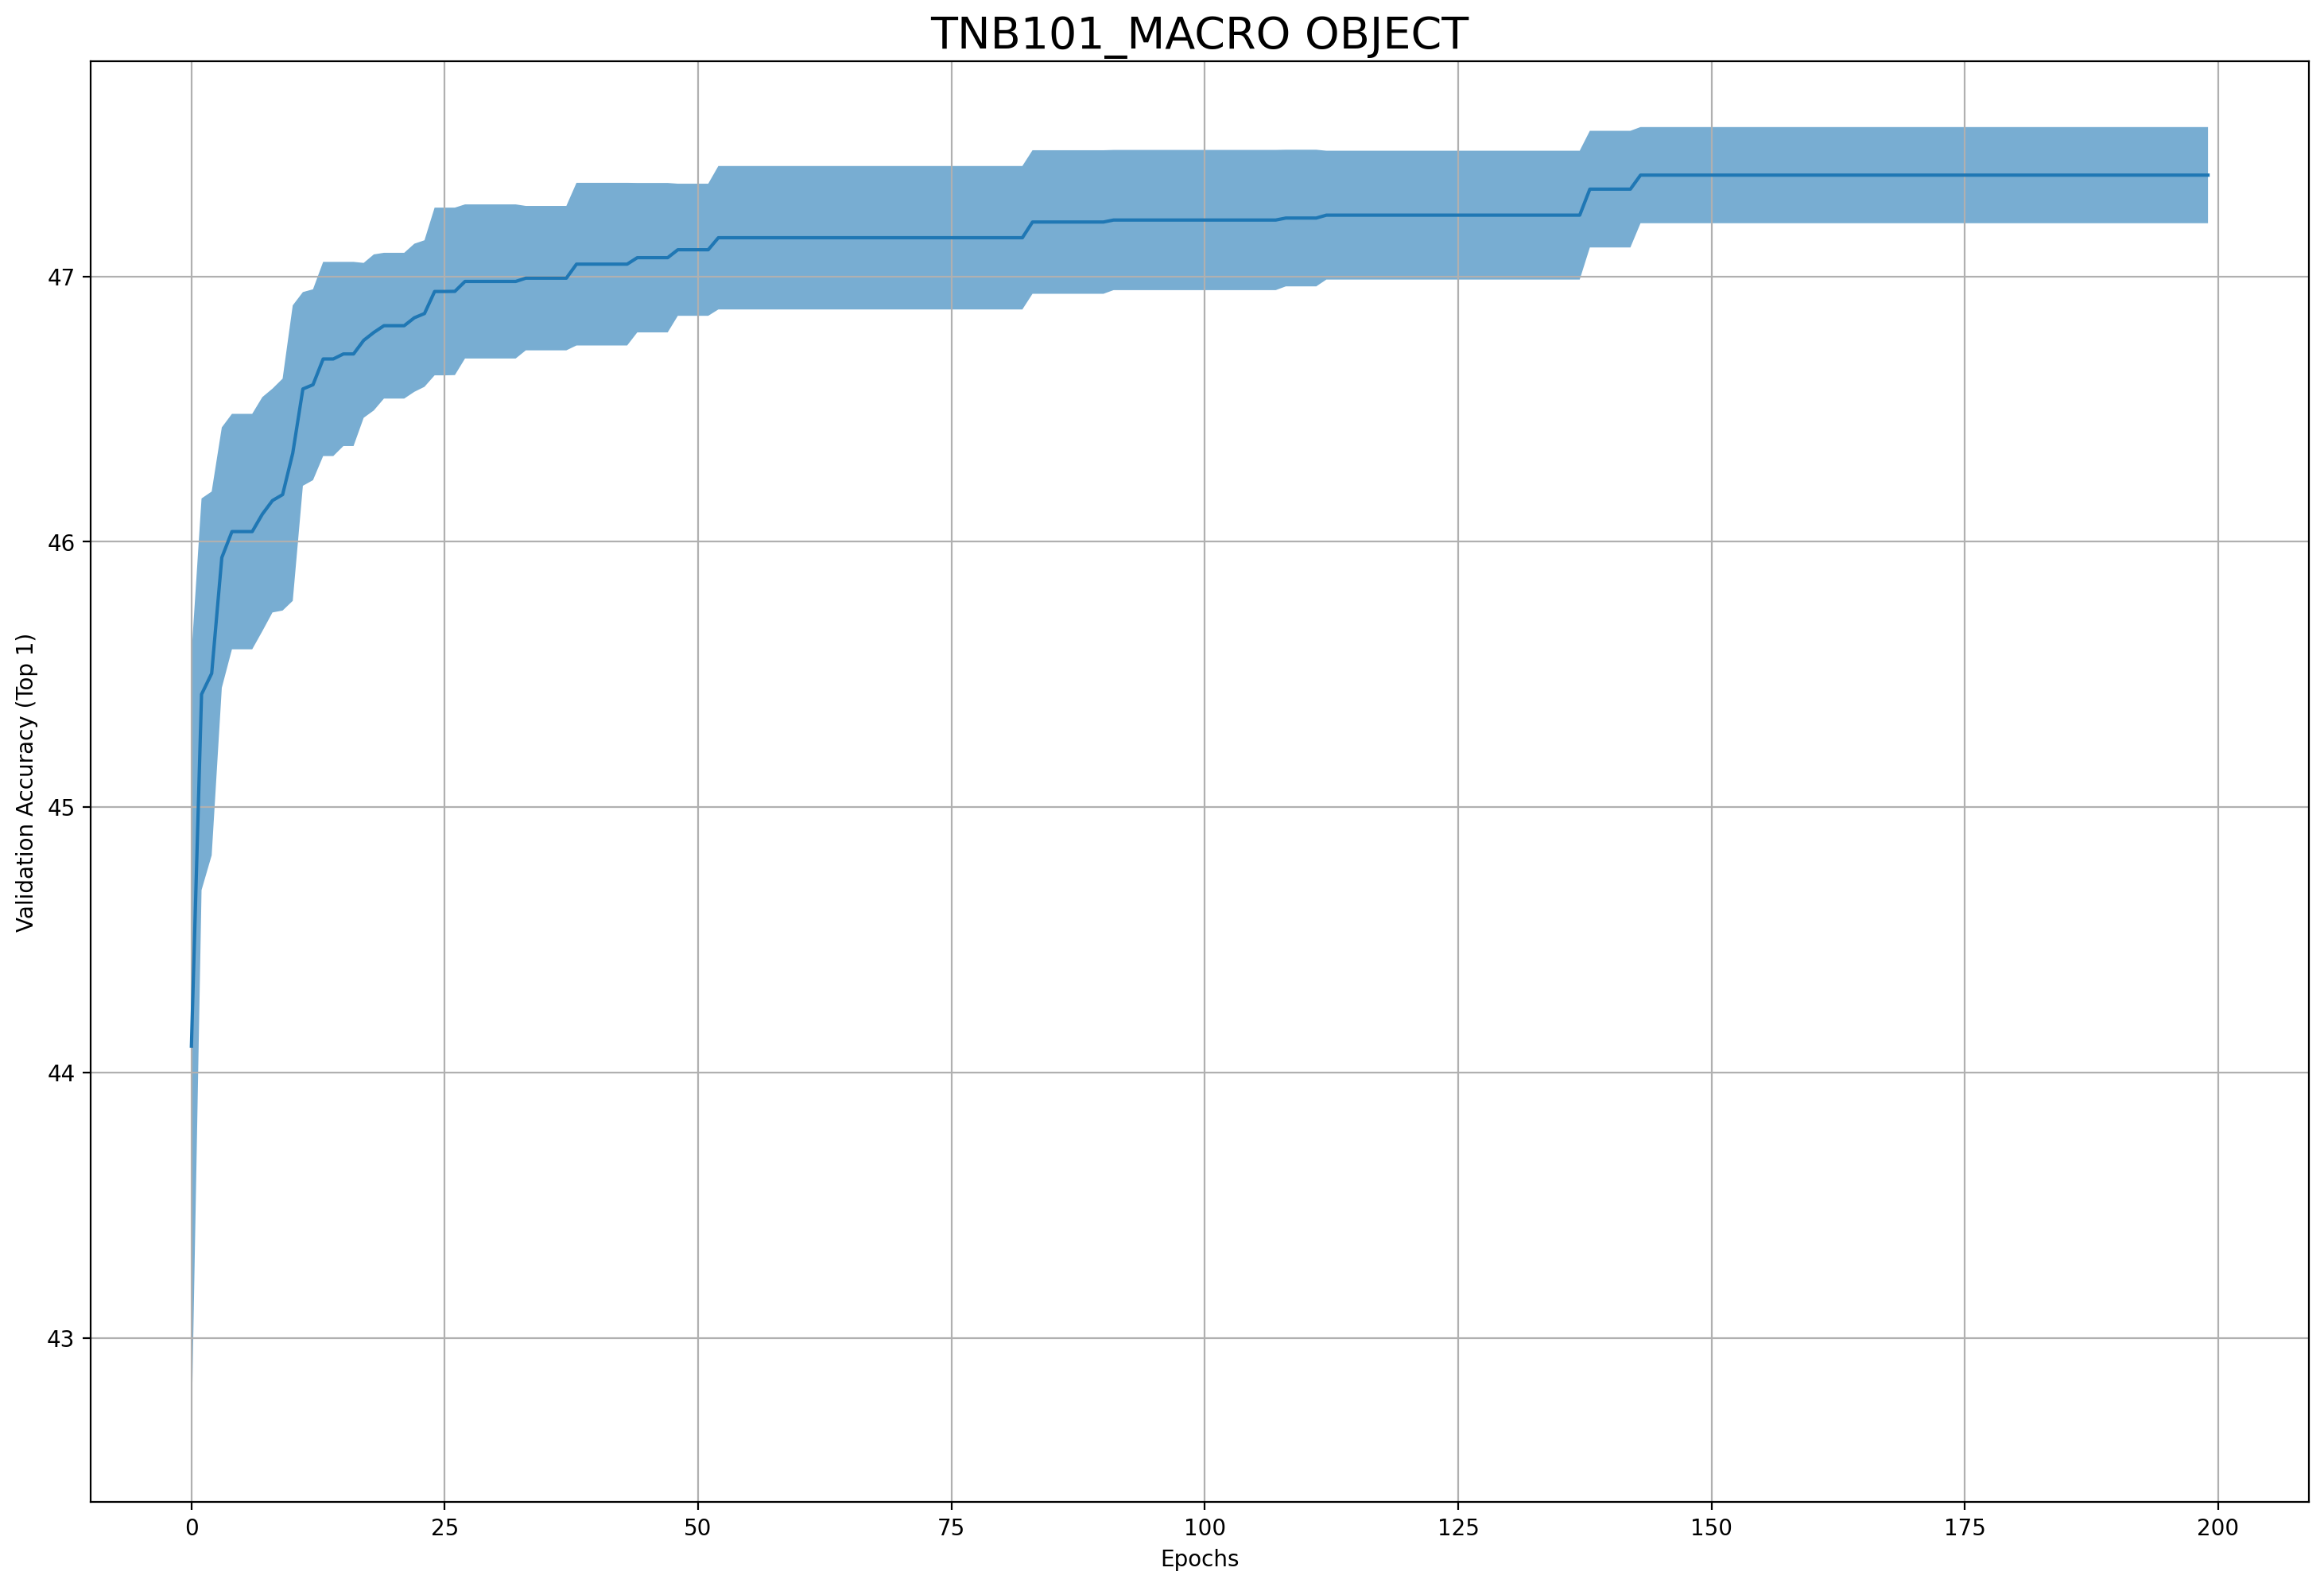

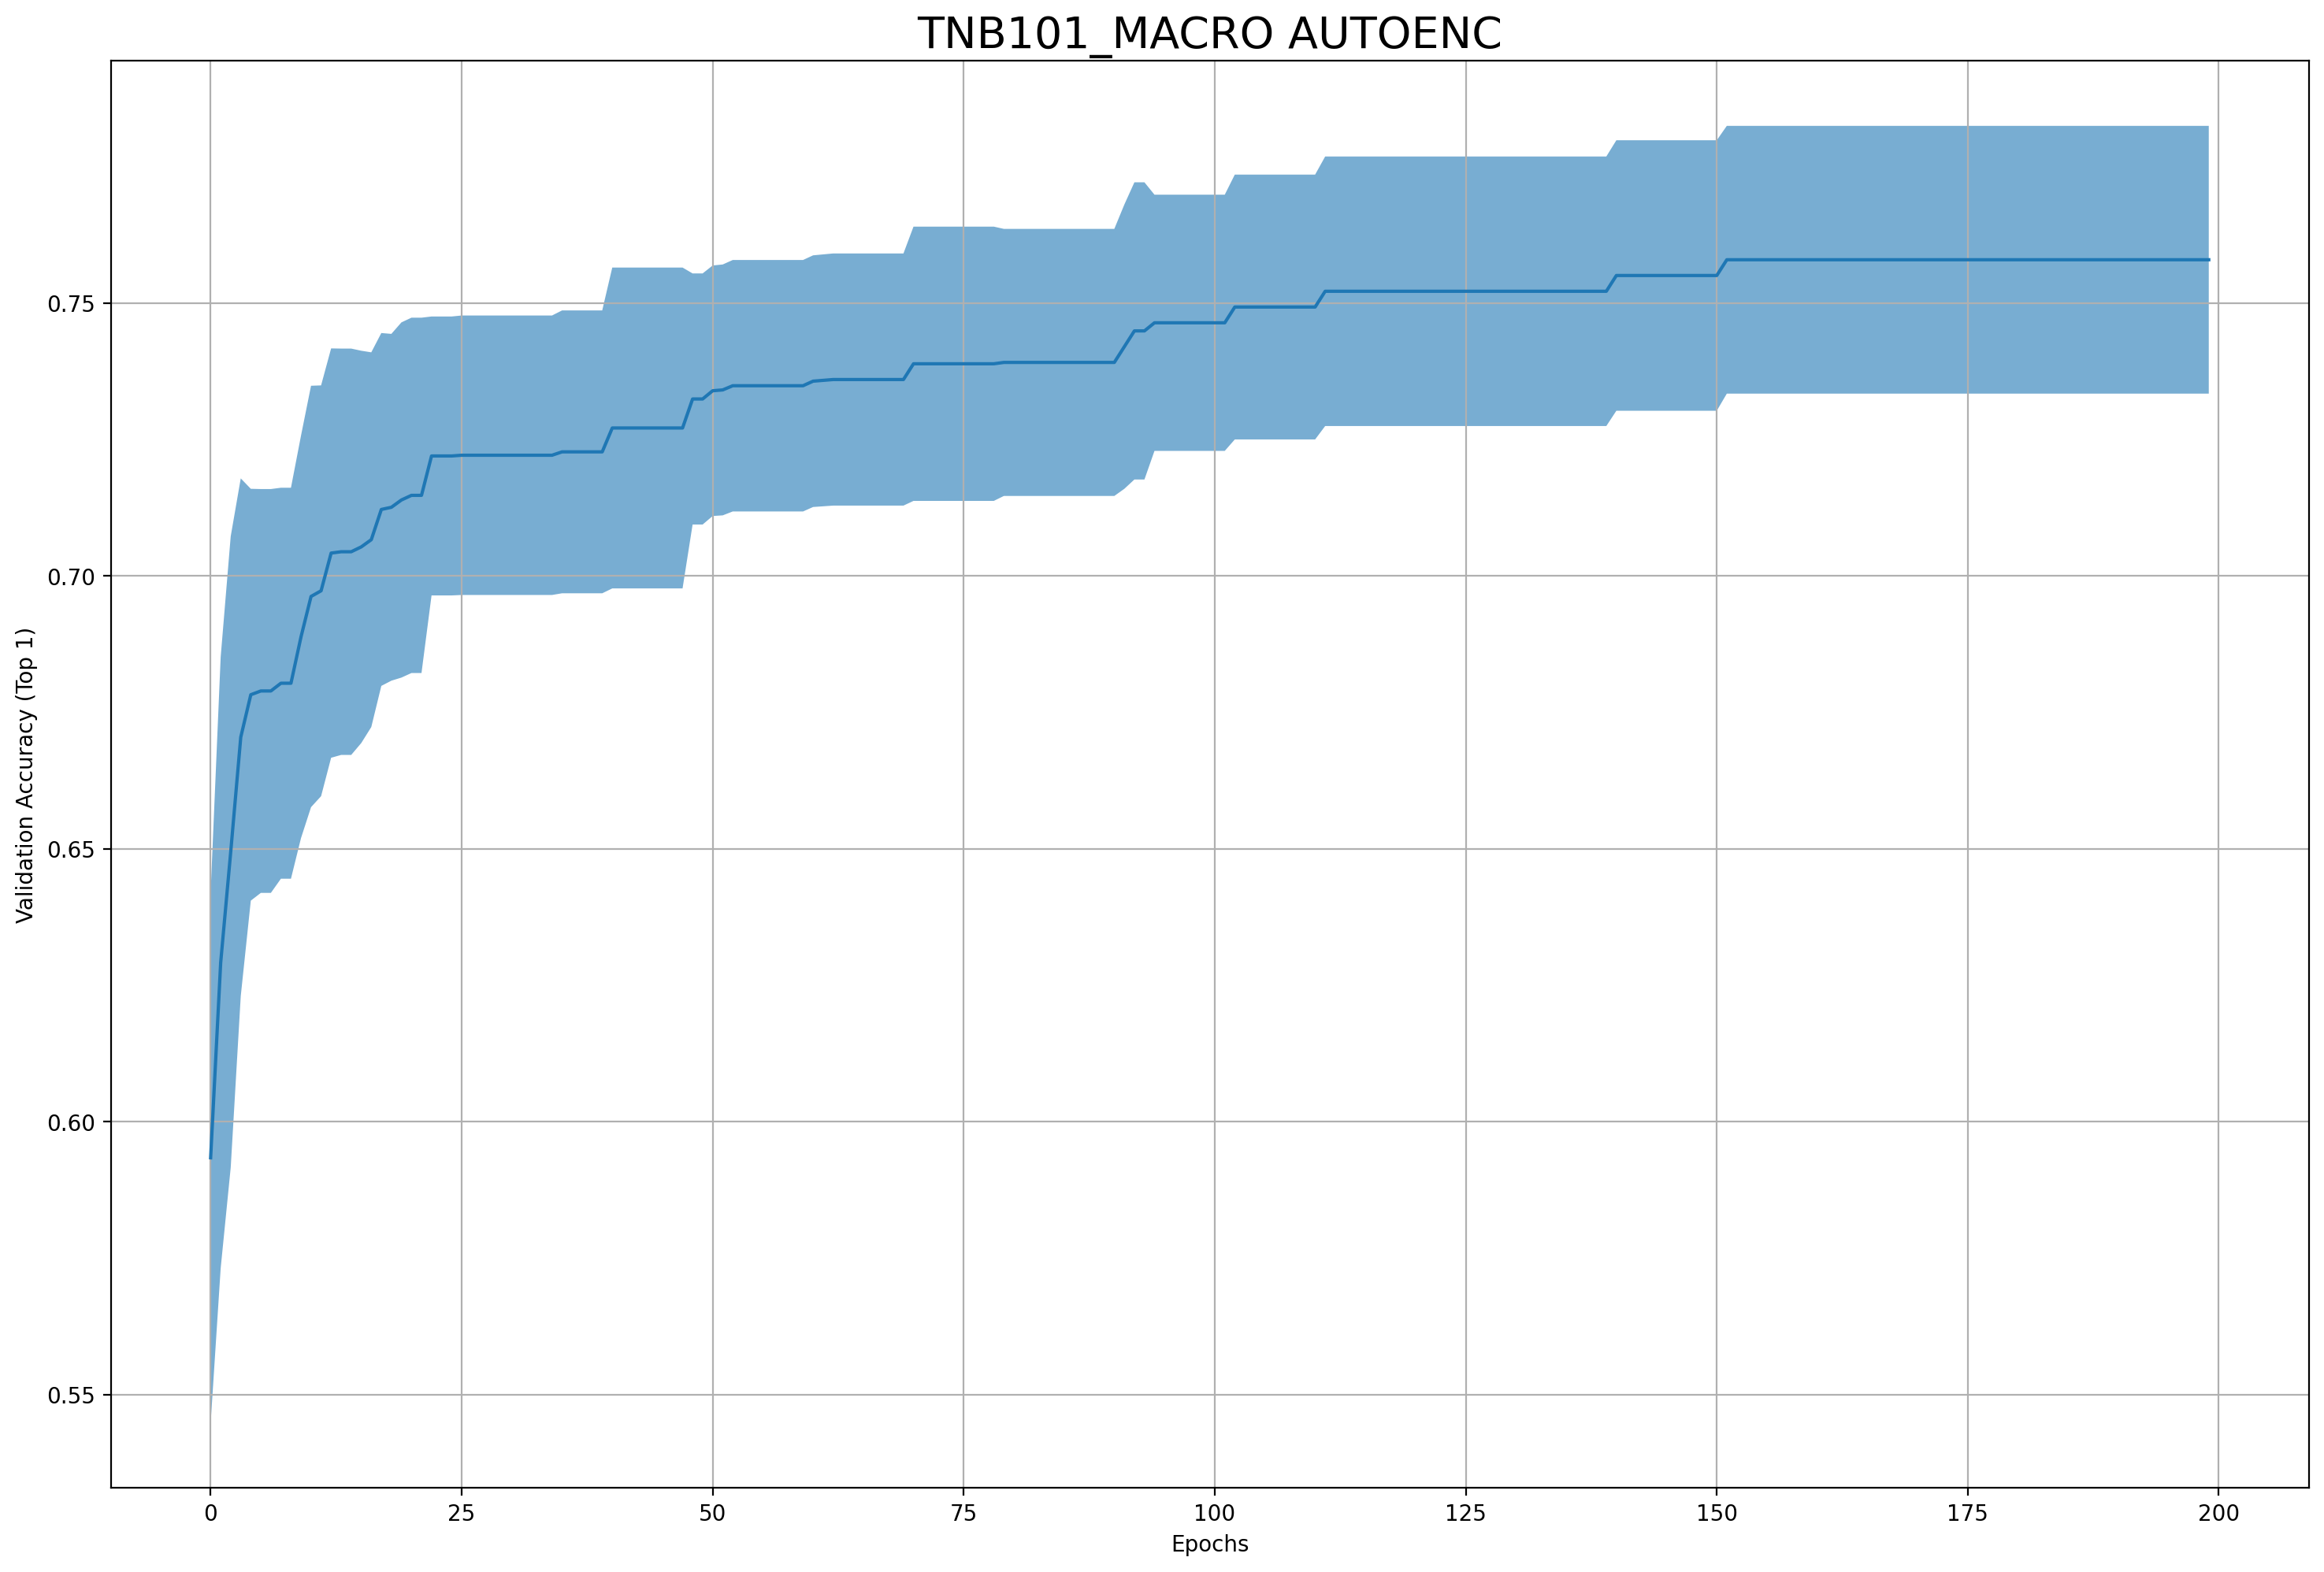

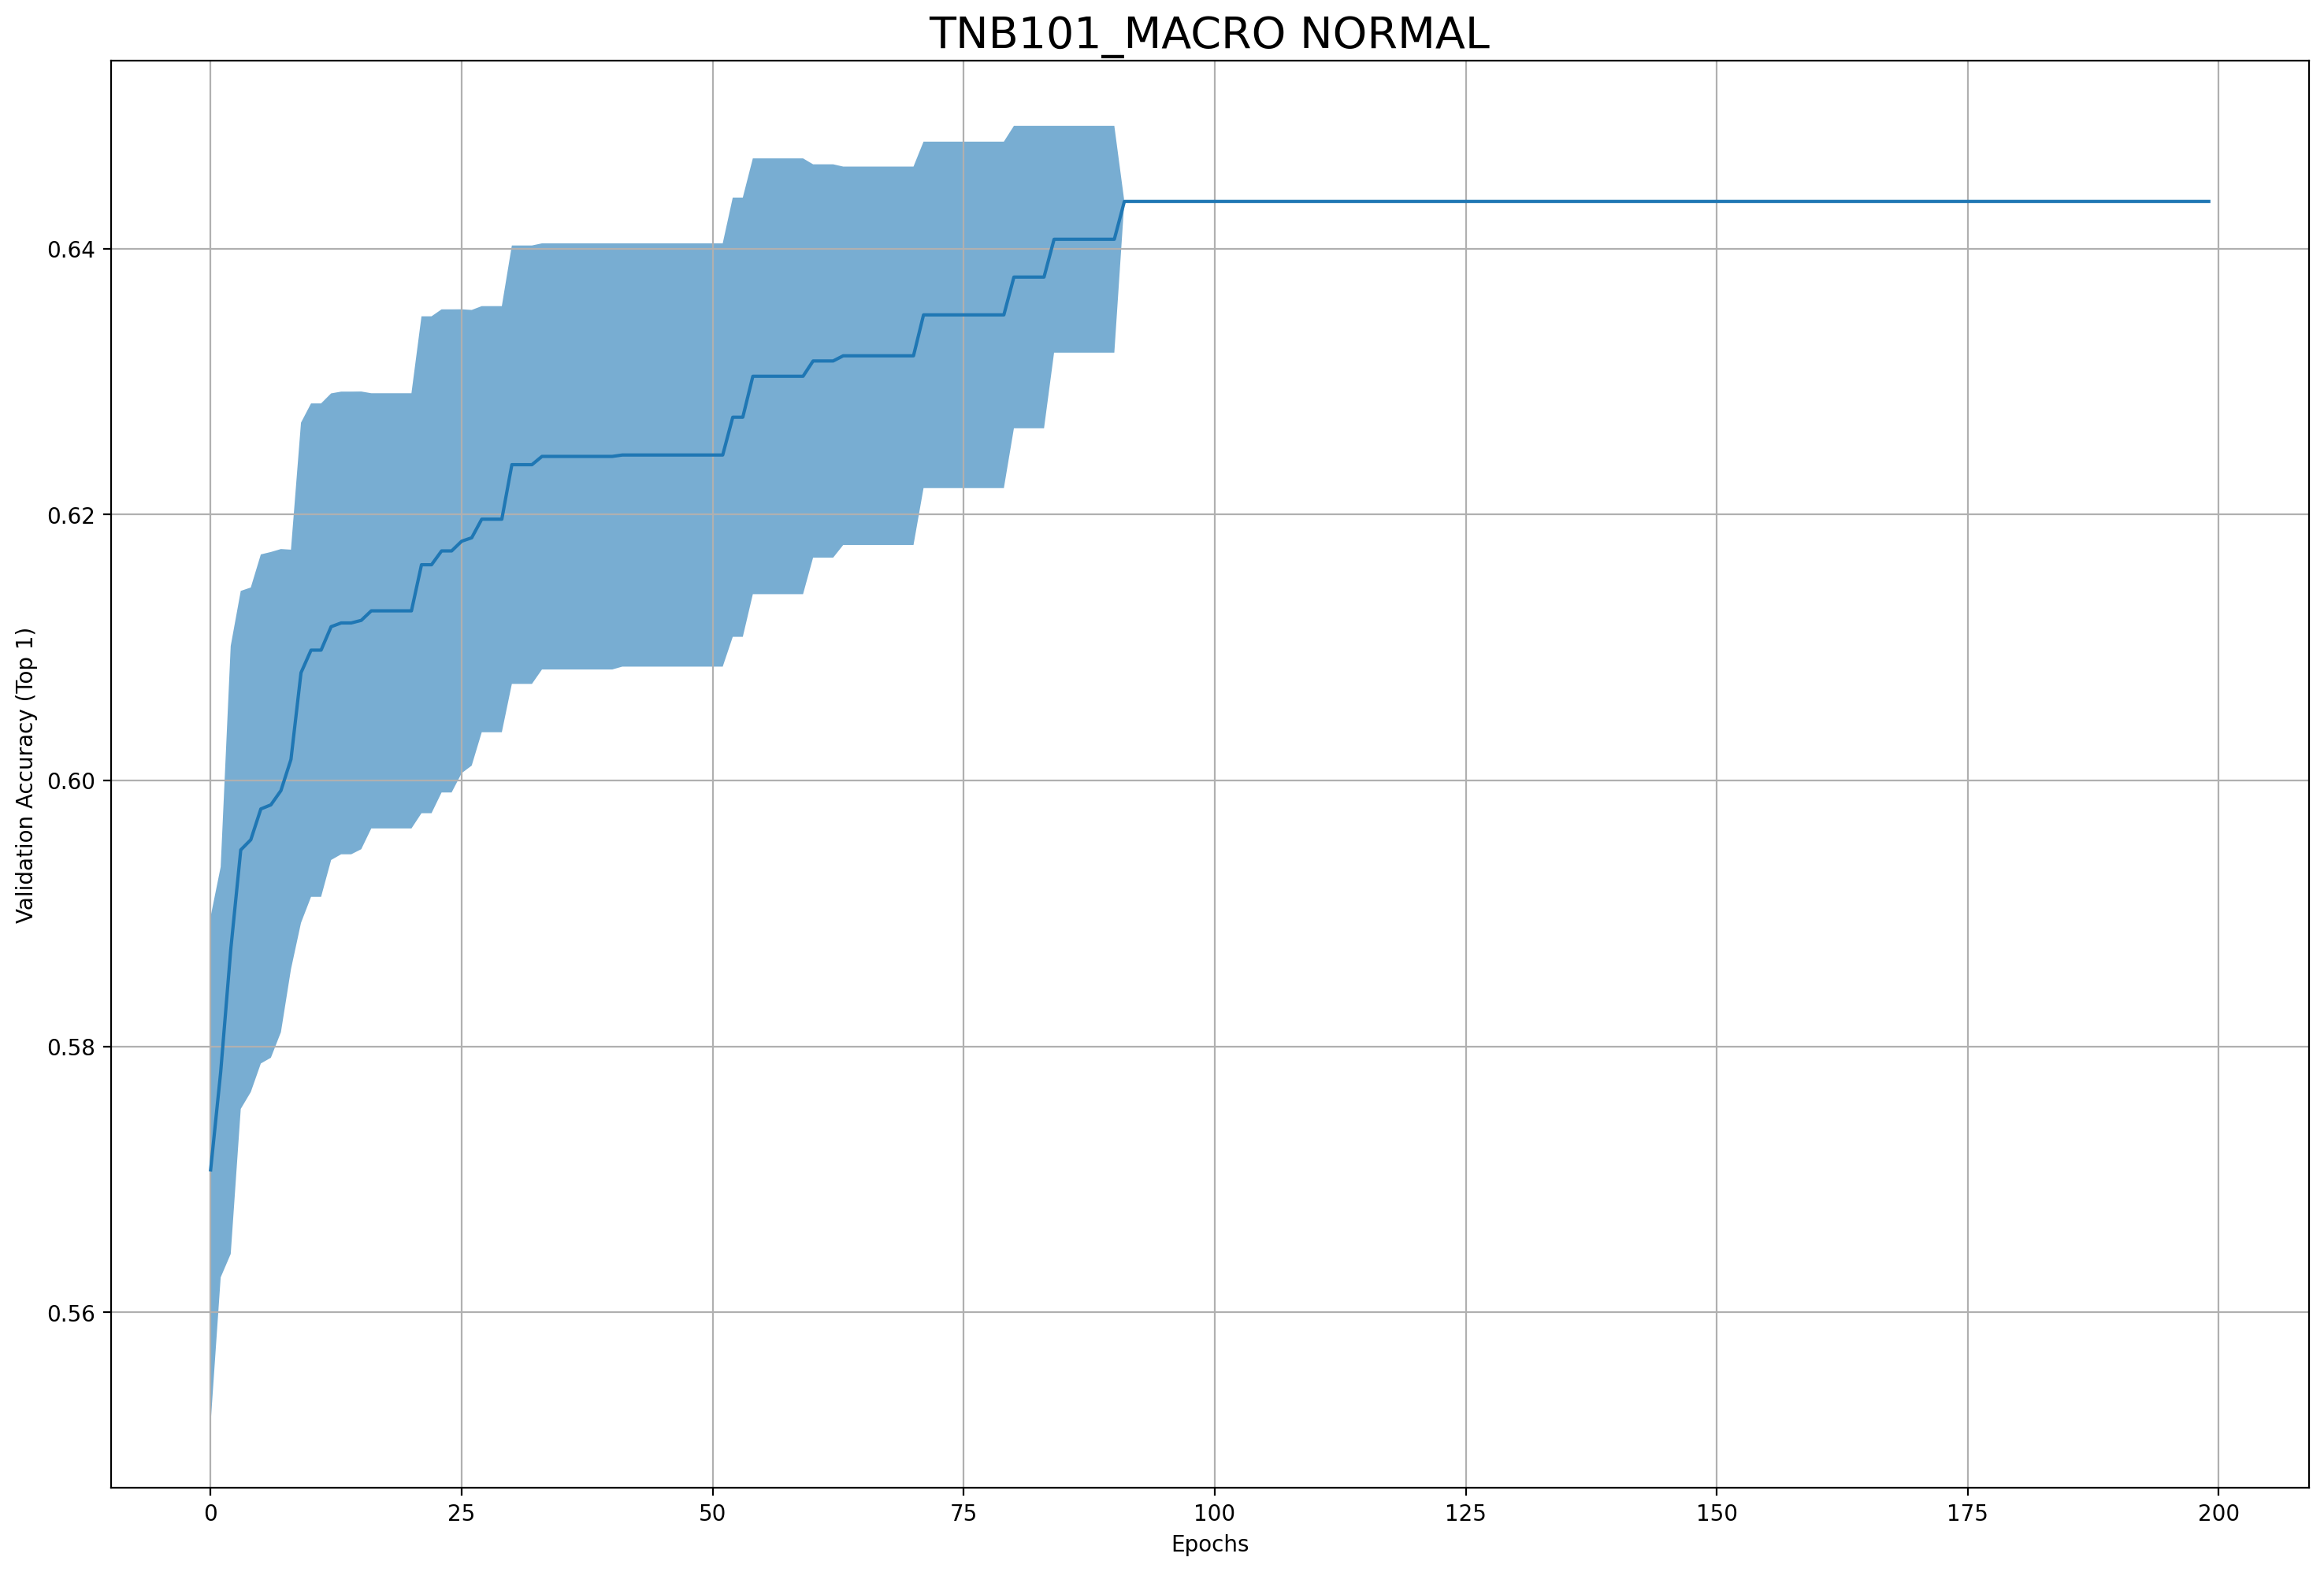

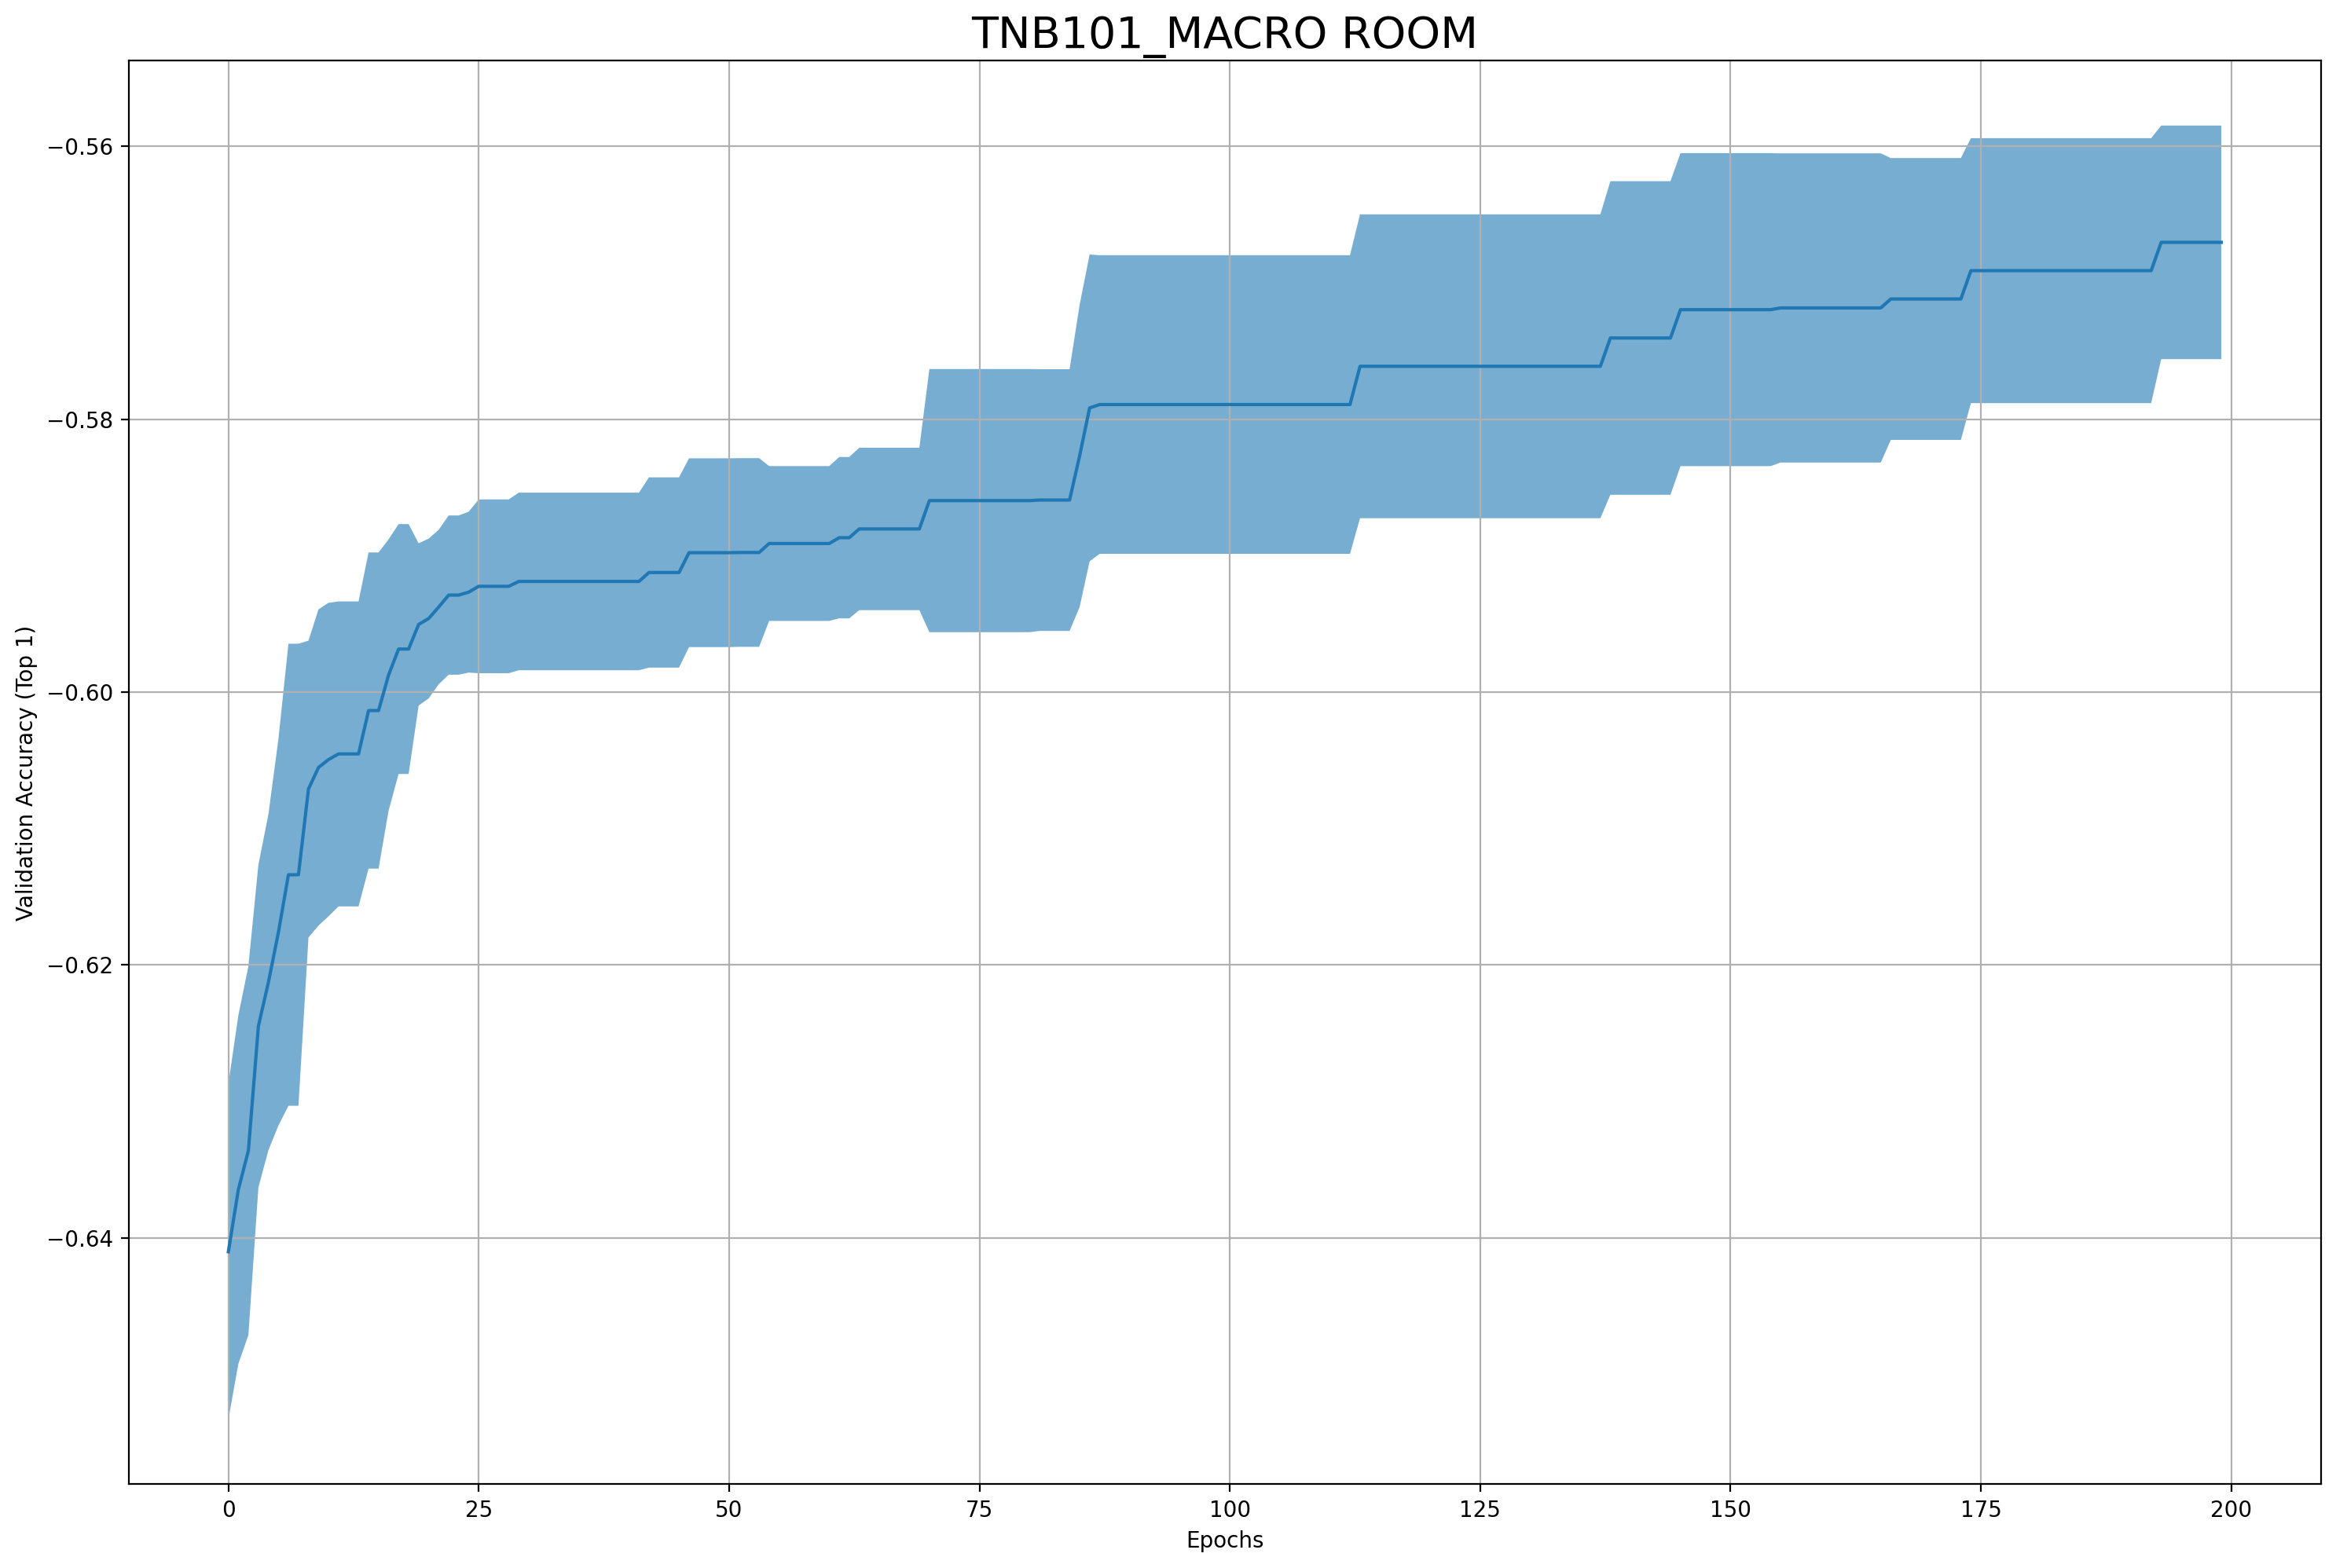

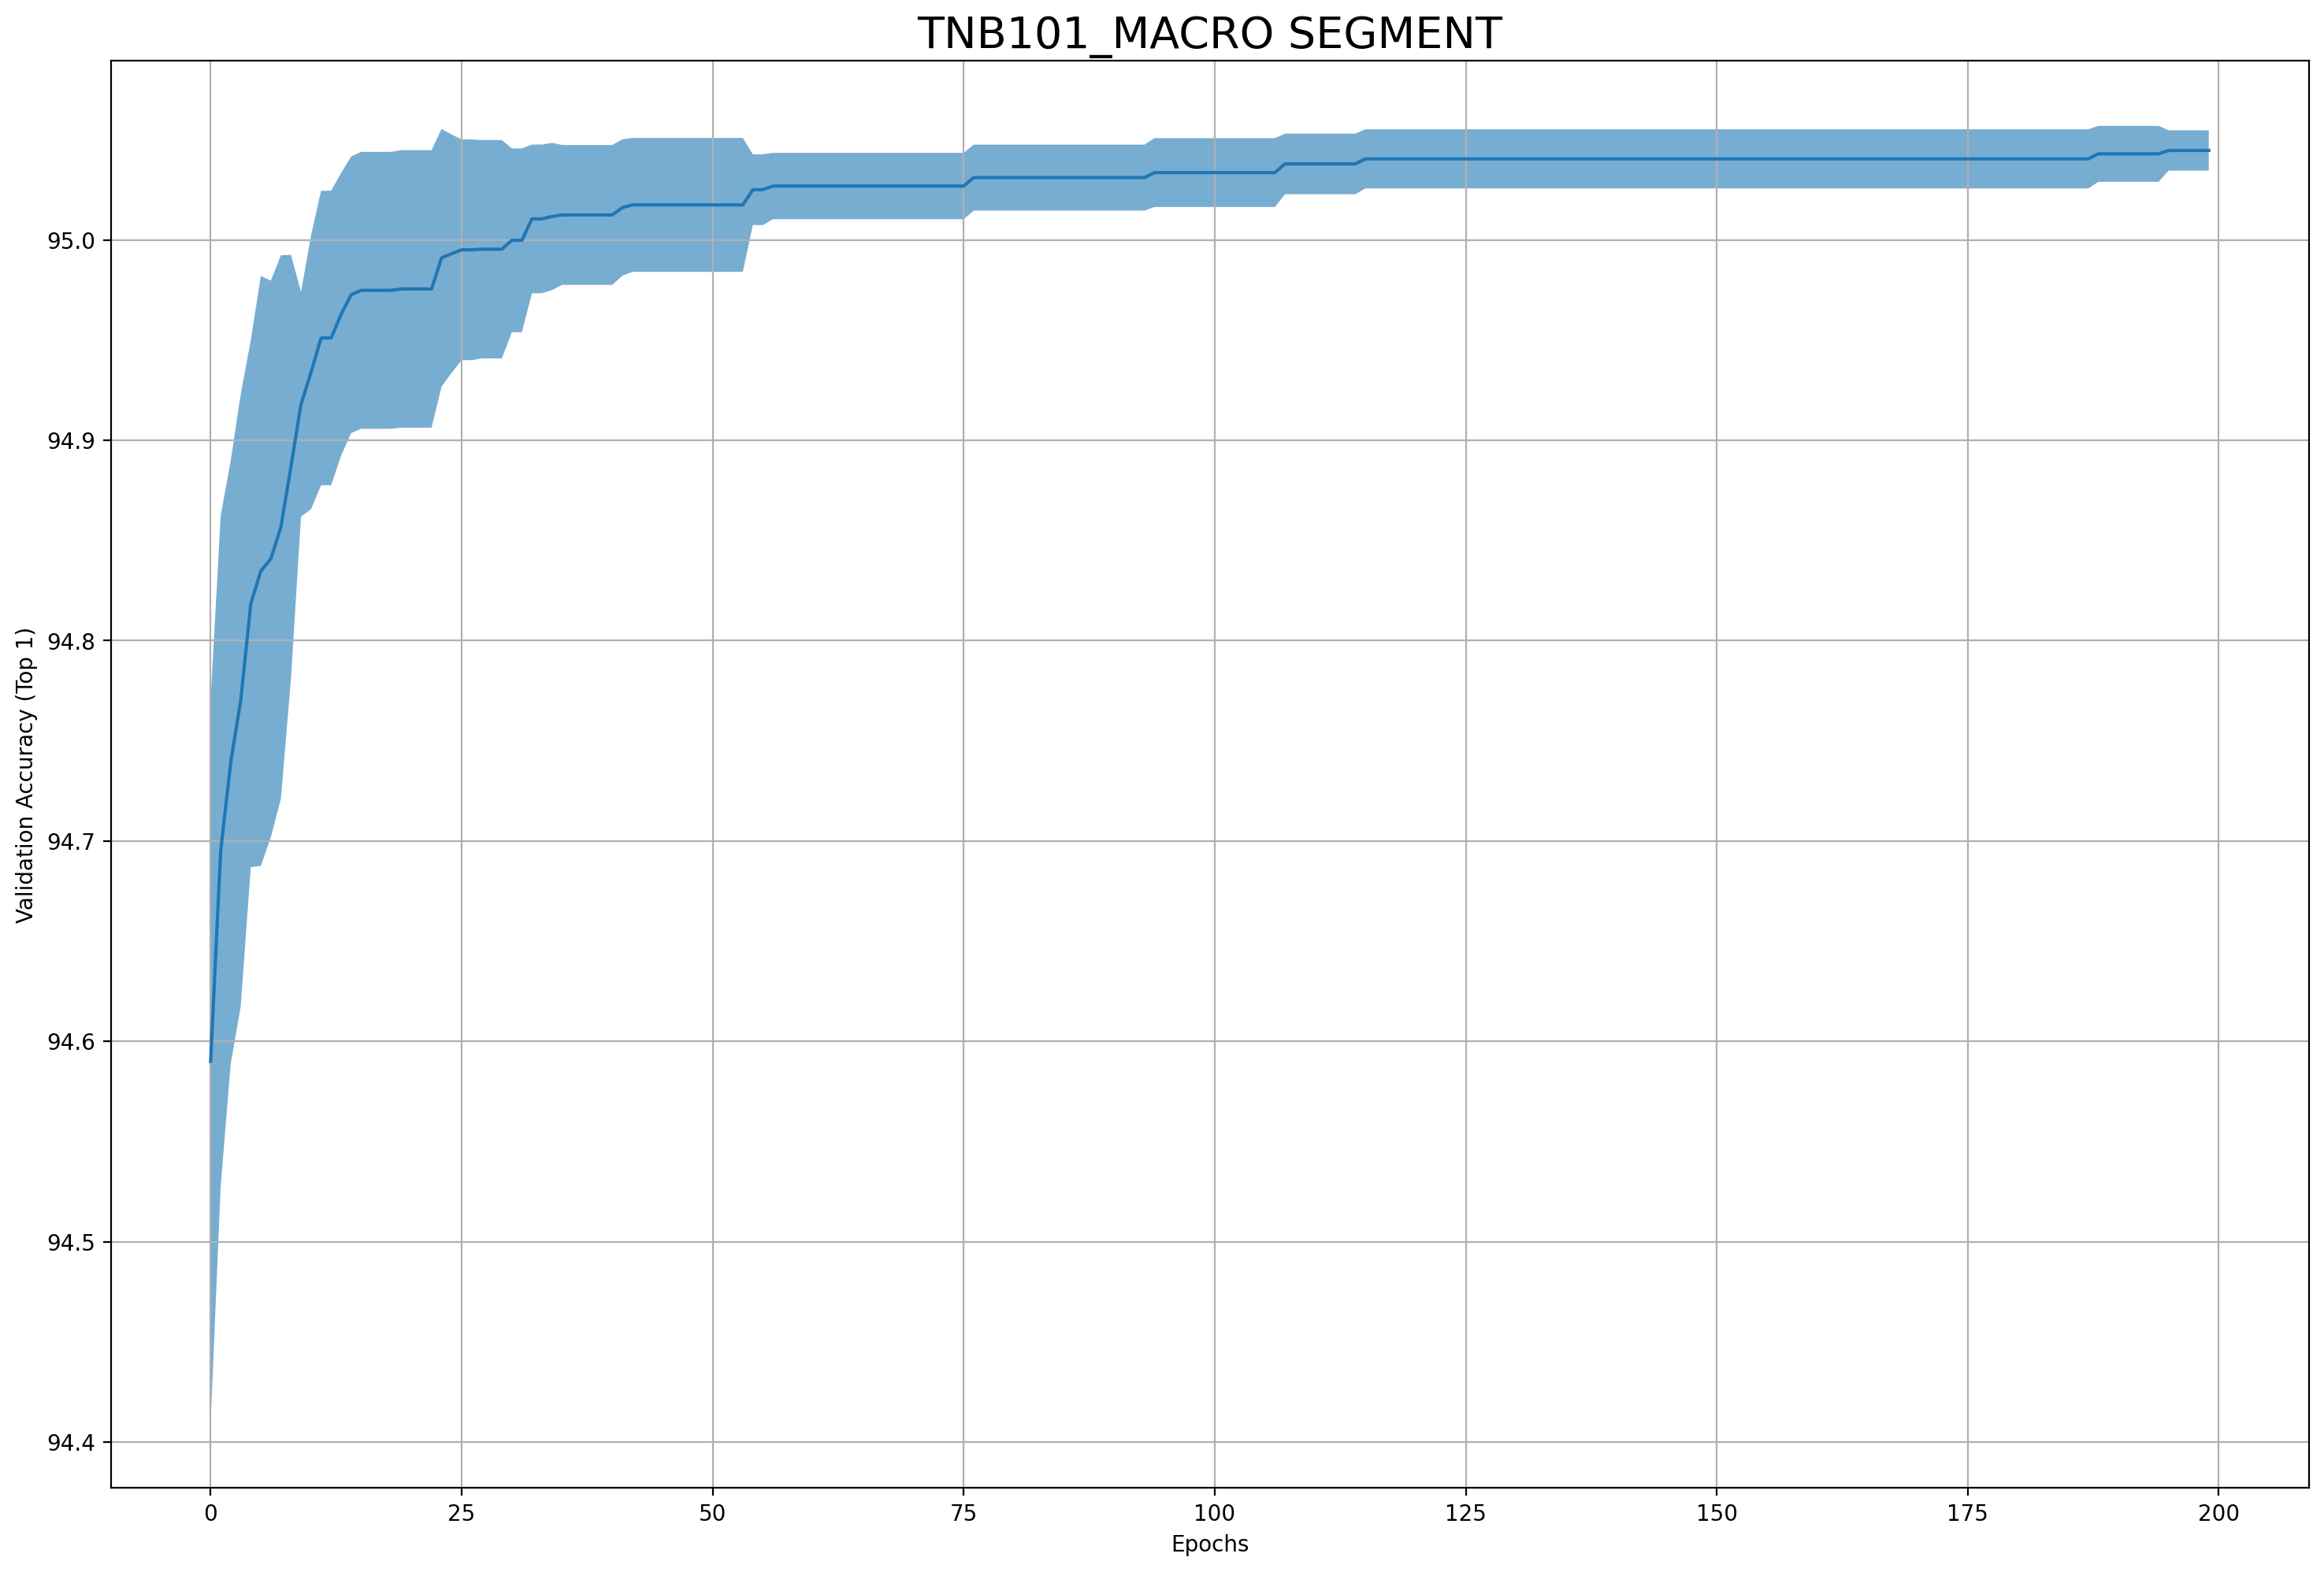

In [11]:
# df = make_df(all_files)
plot_for_search_space(df, 'transbench101_macro')

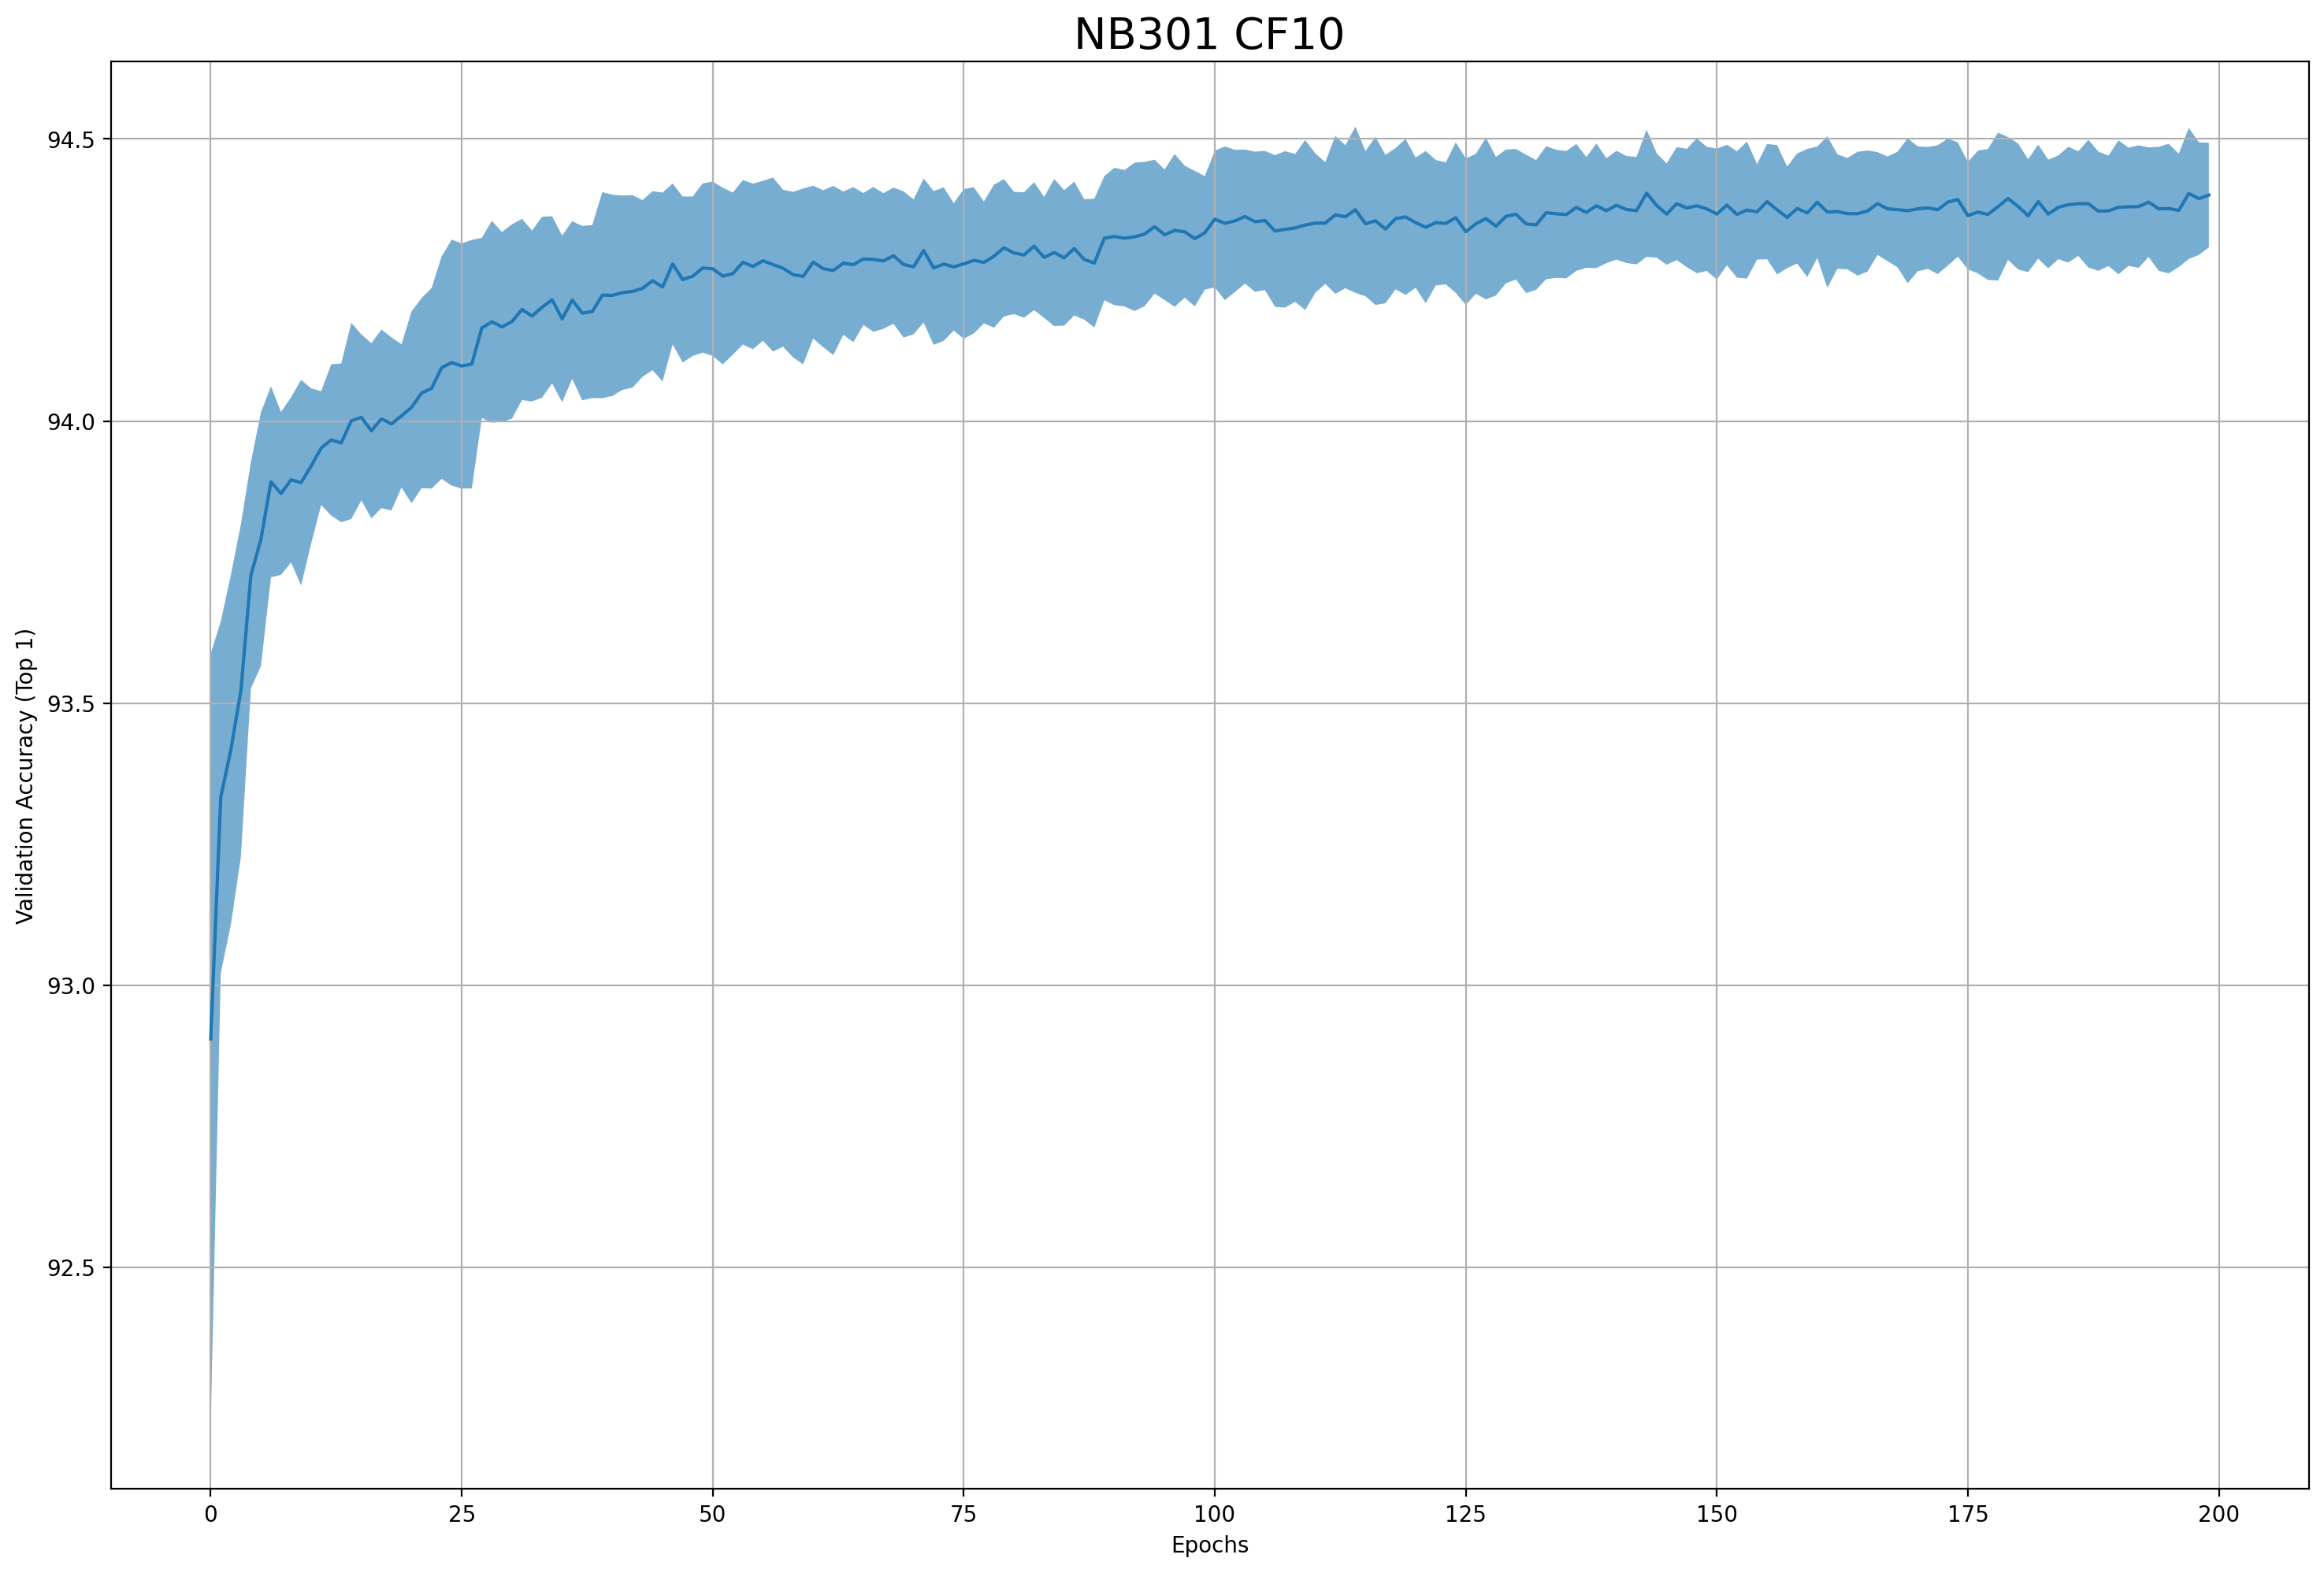

In [12]:
plot_for_search_space(df, 'nasbench301')

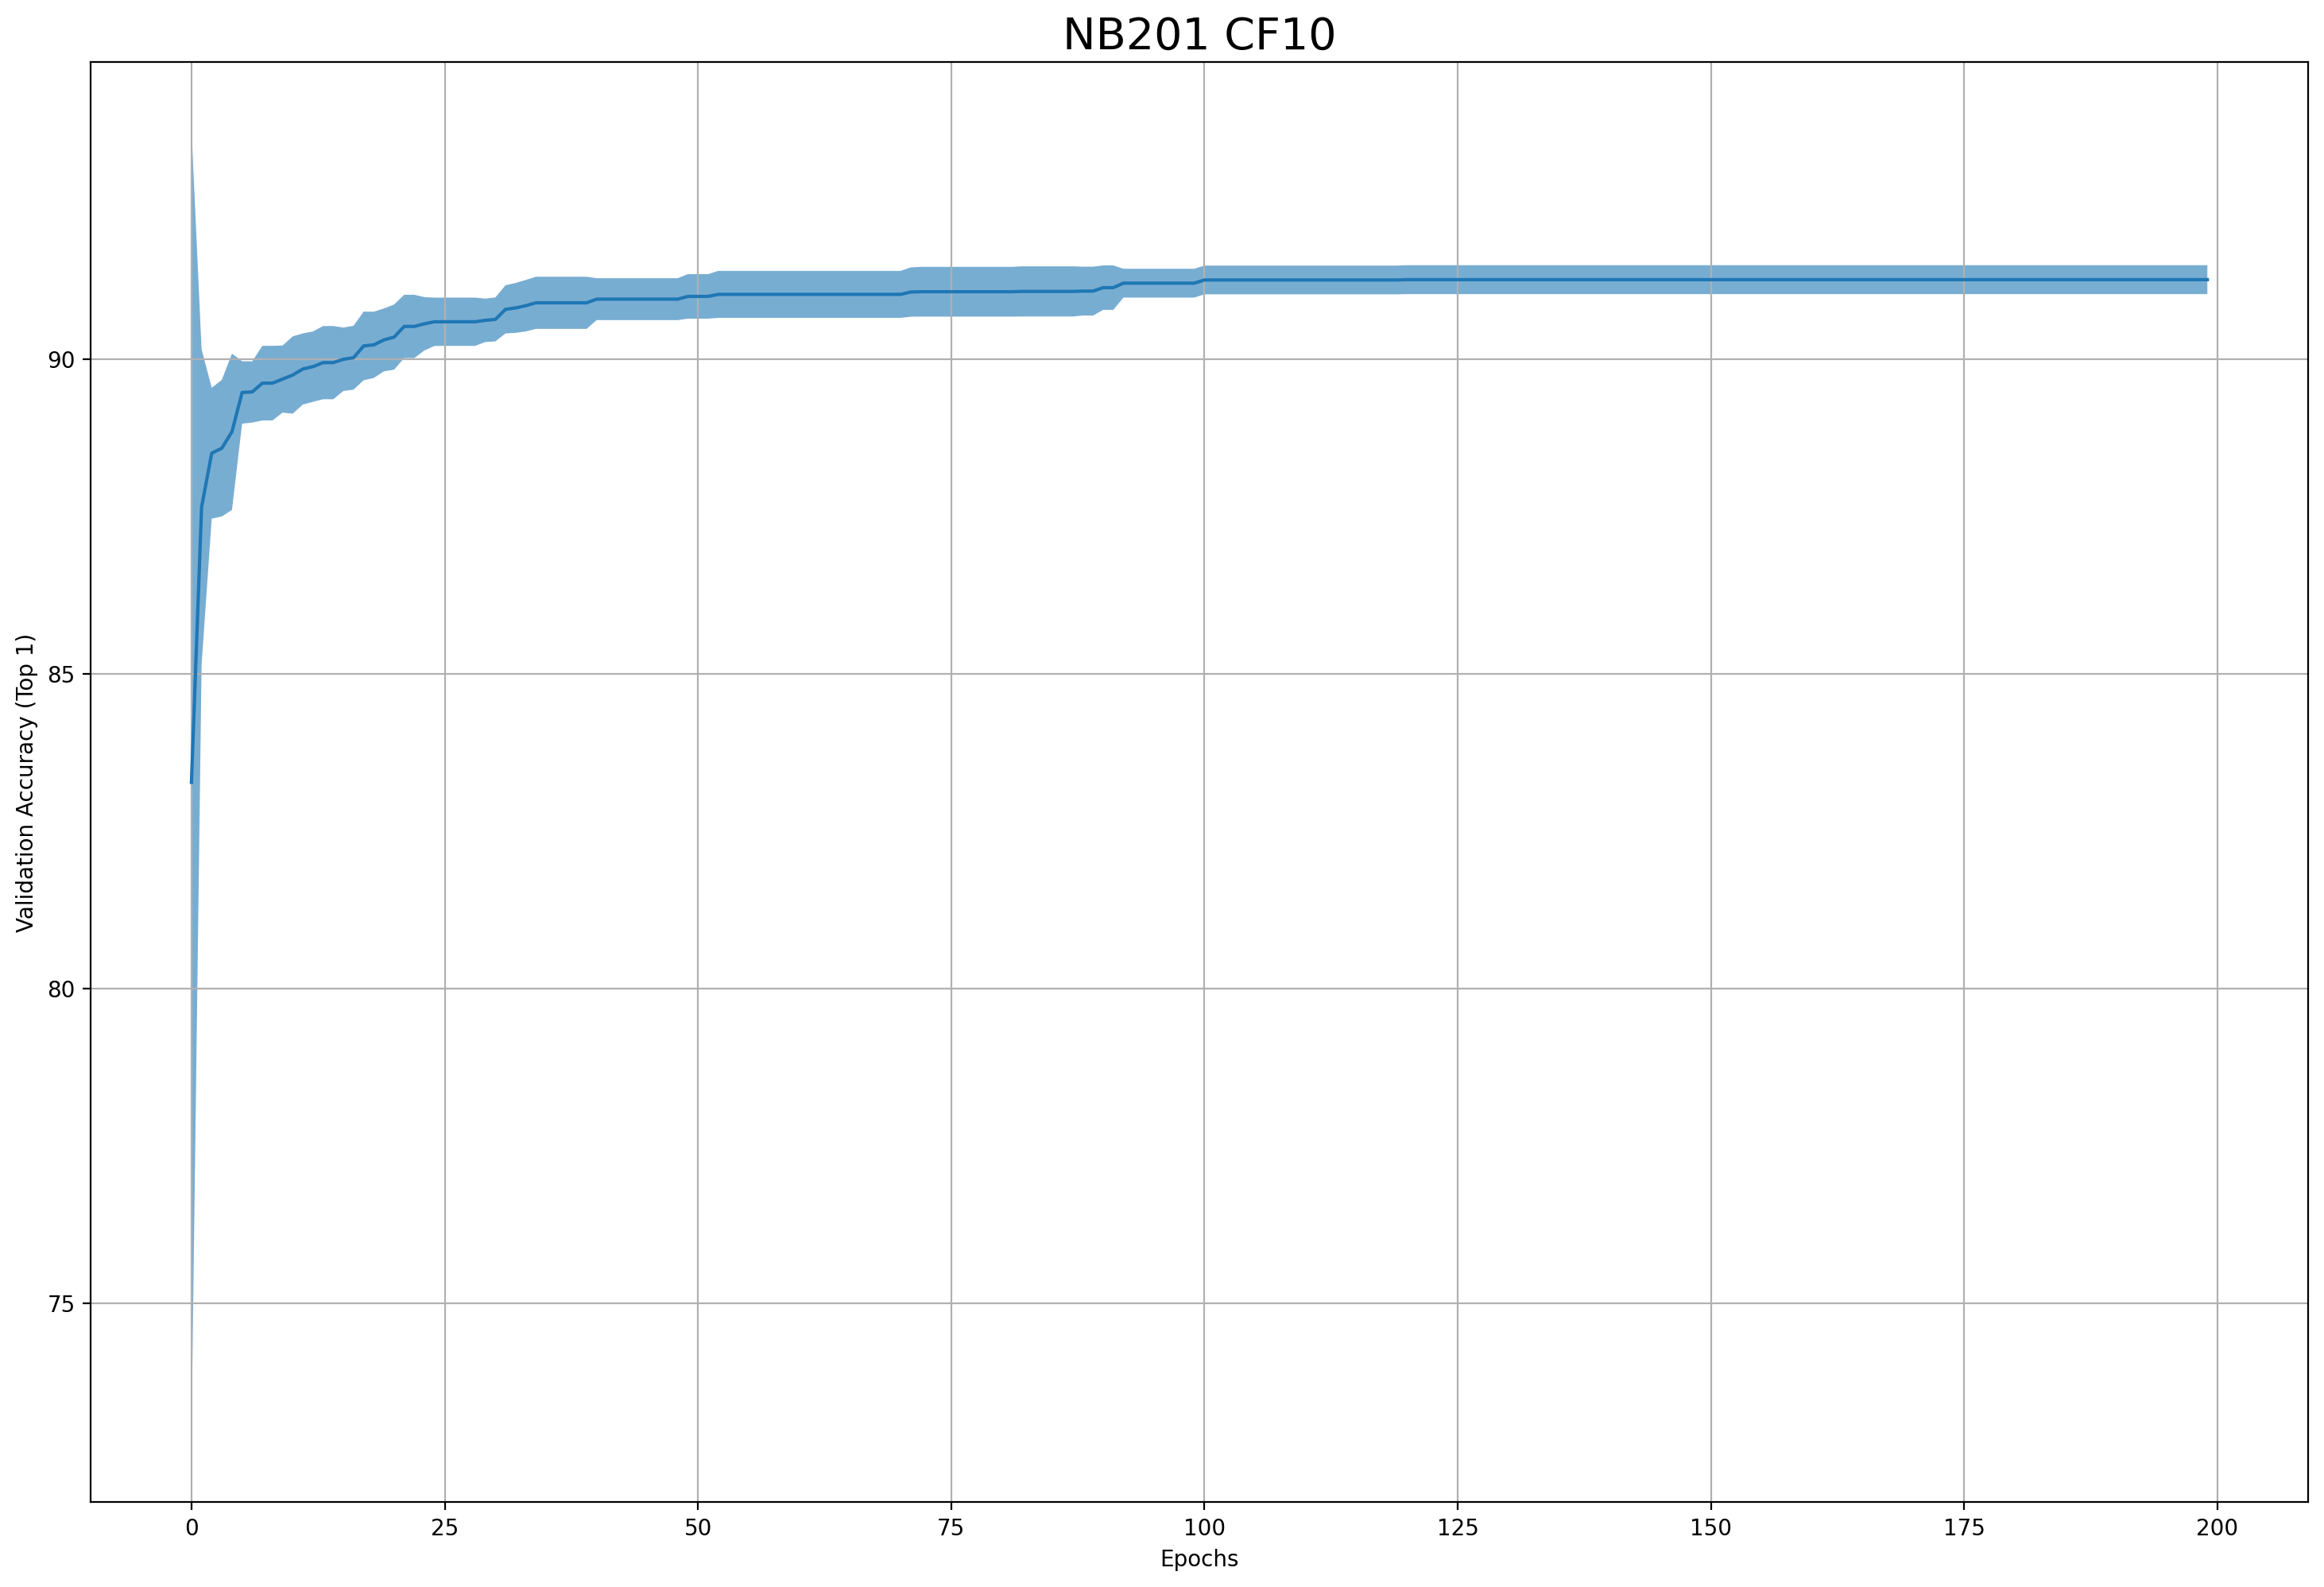

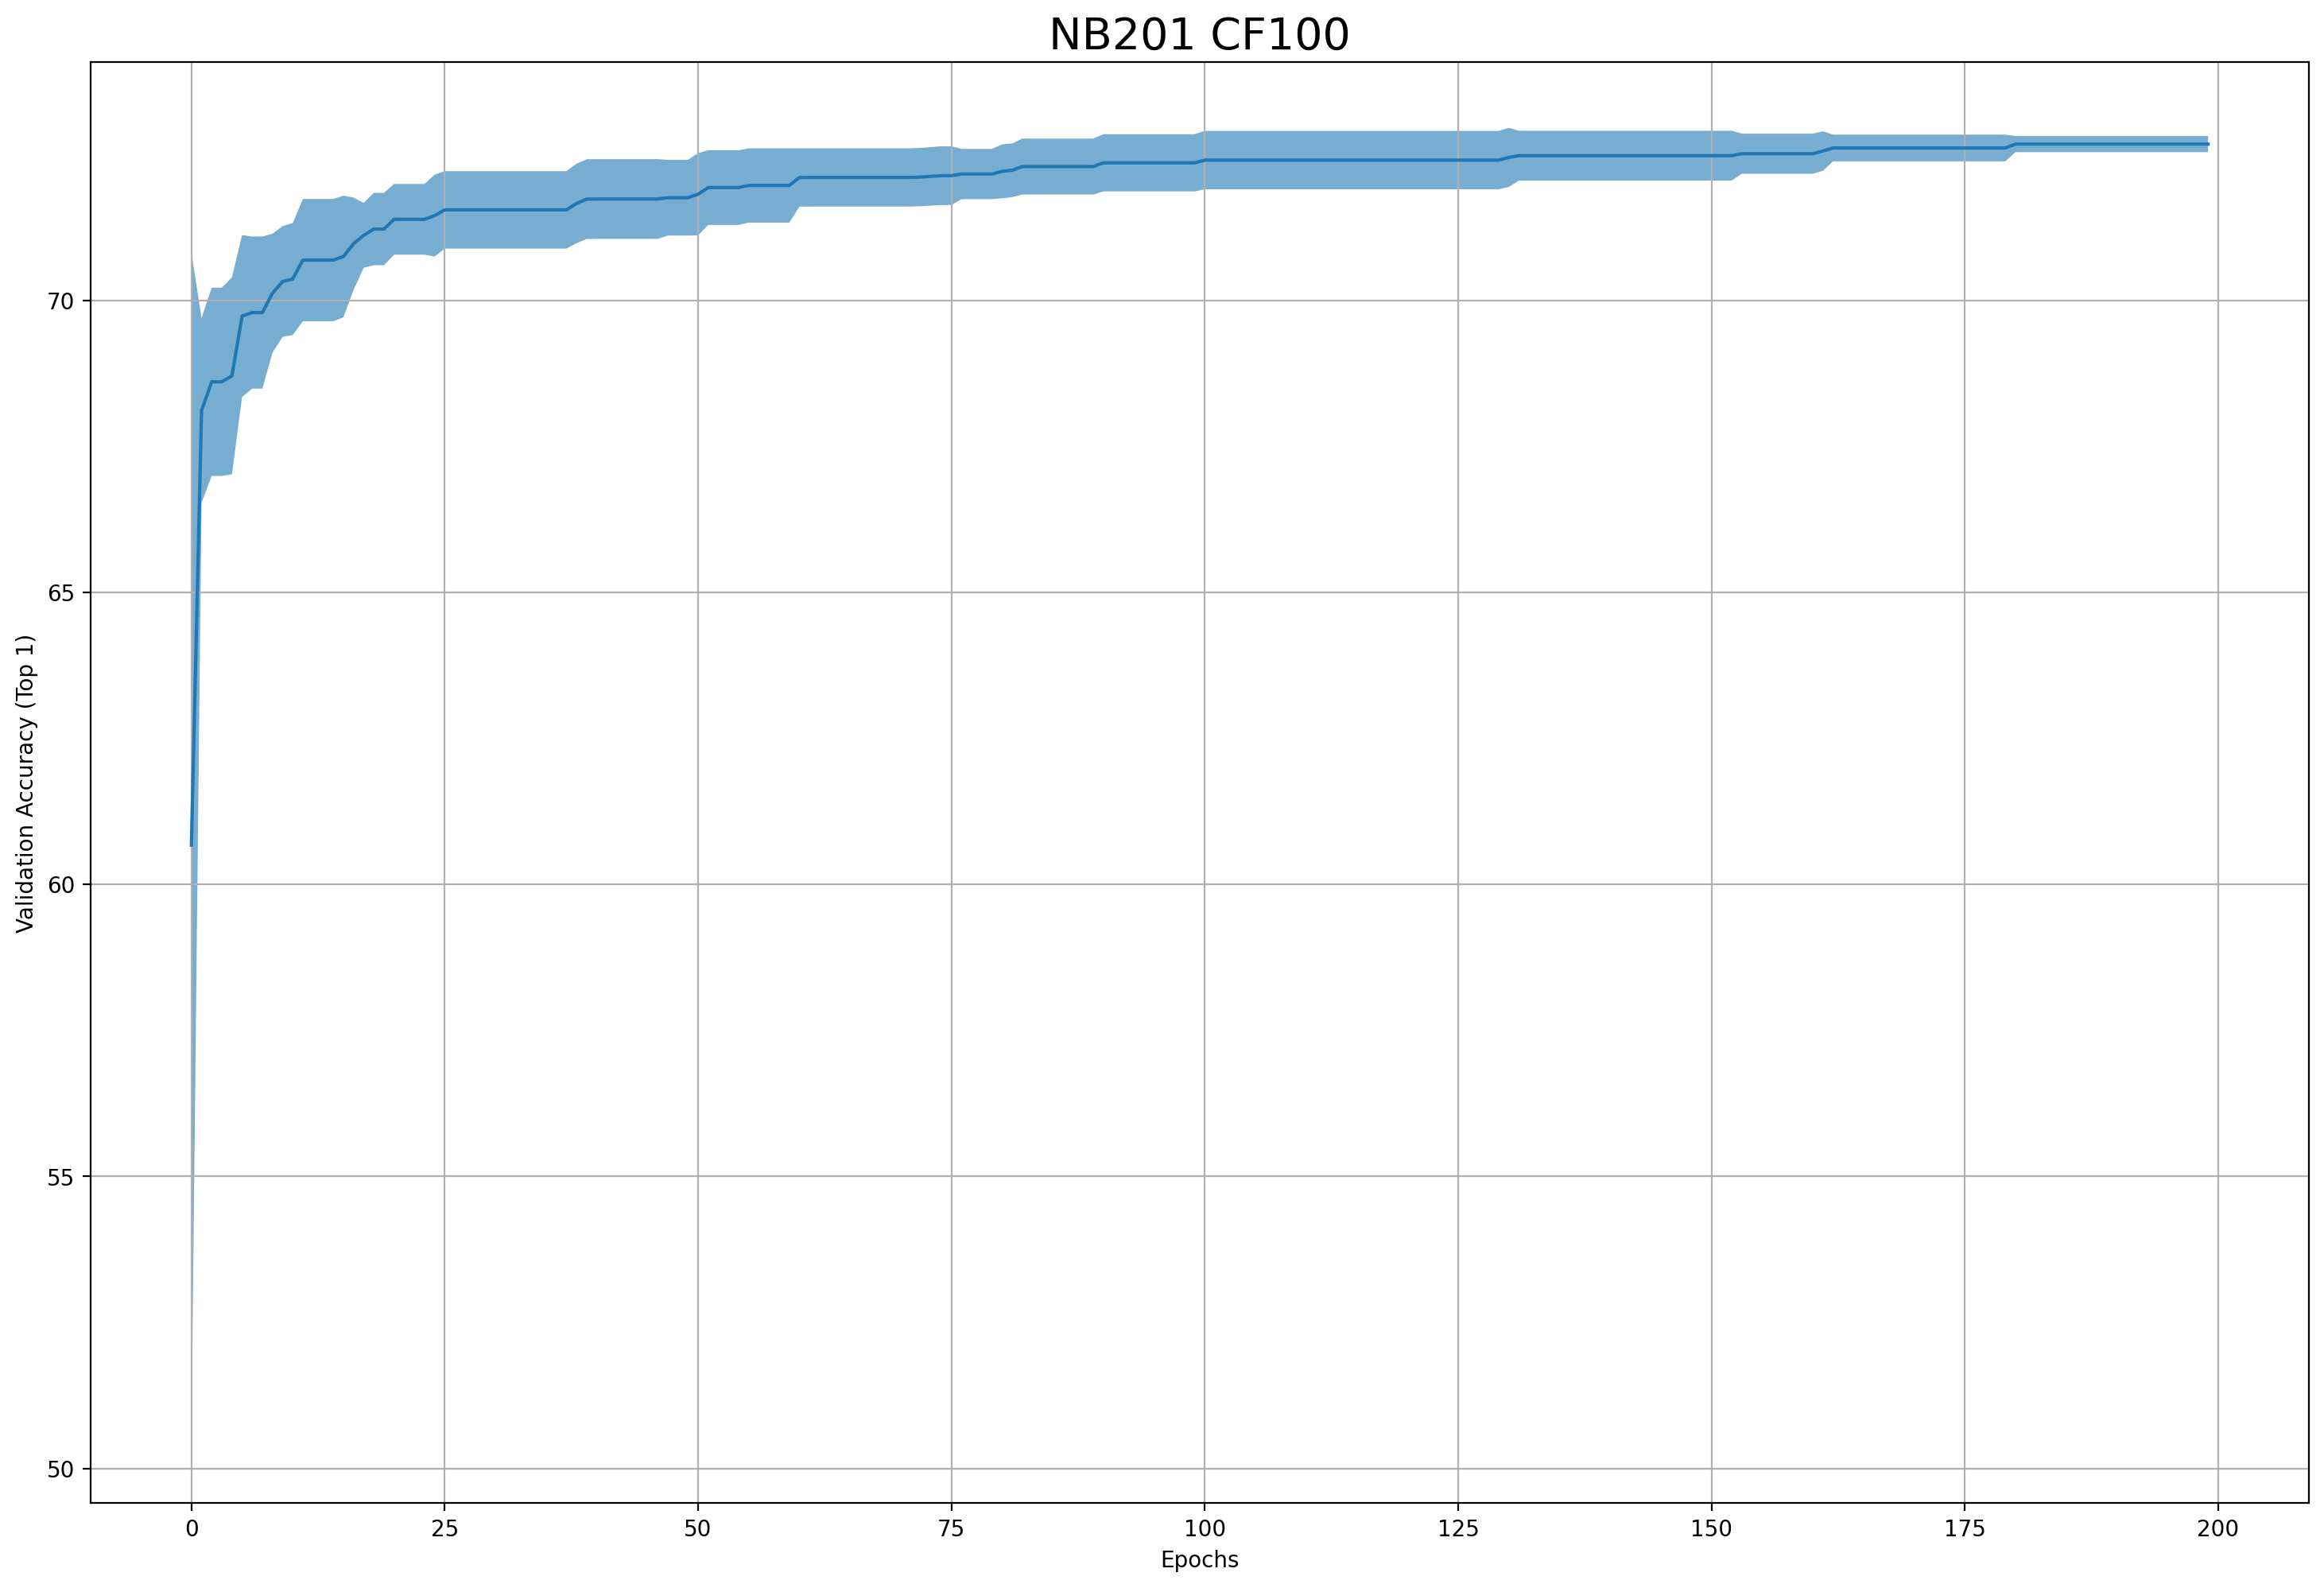

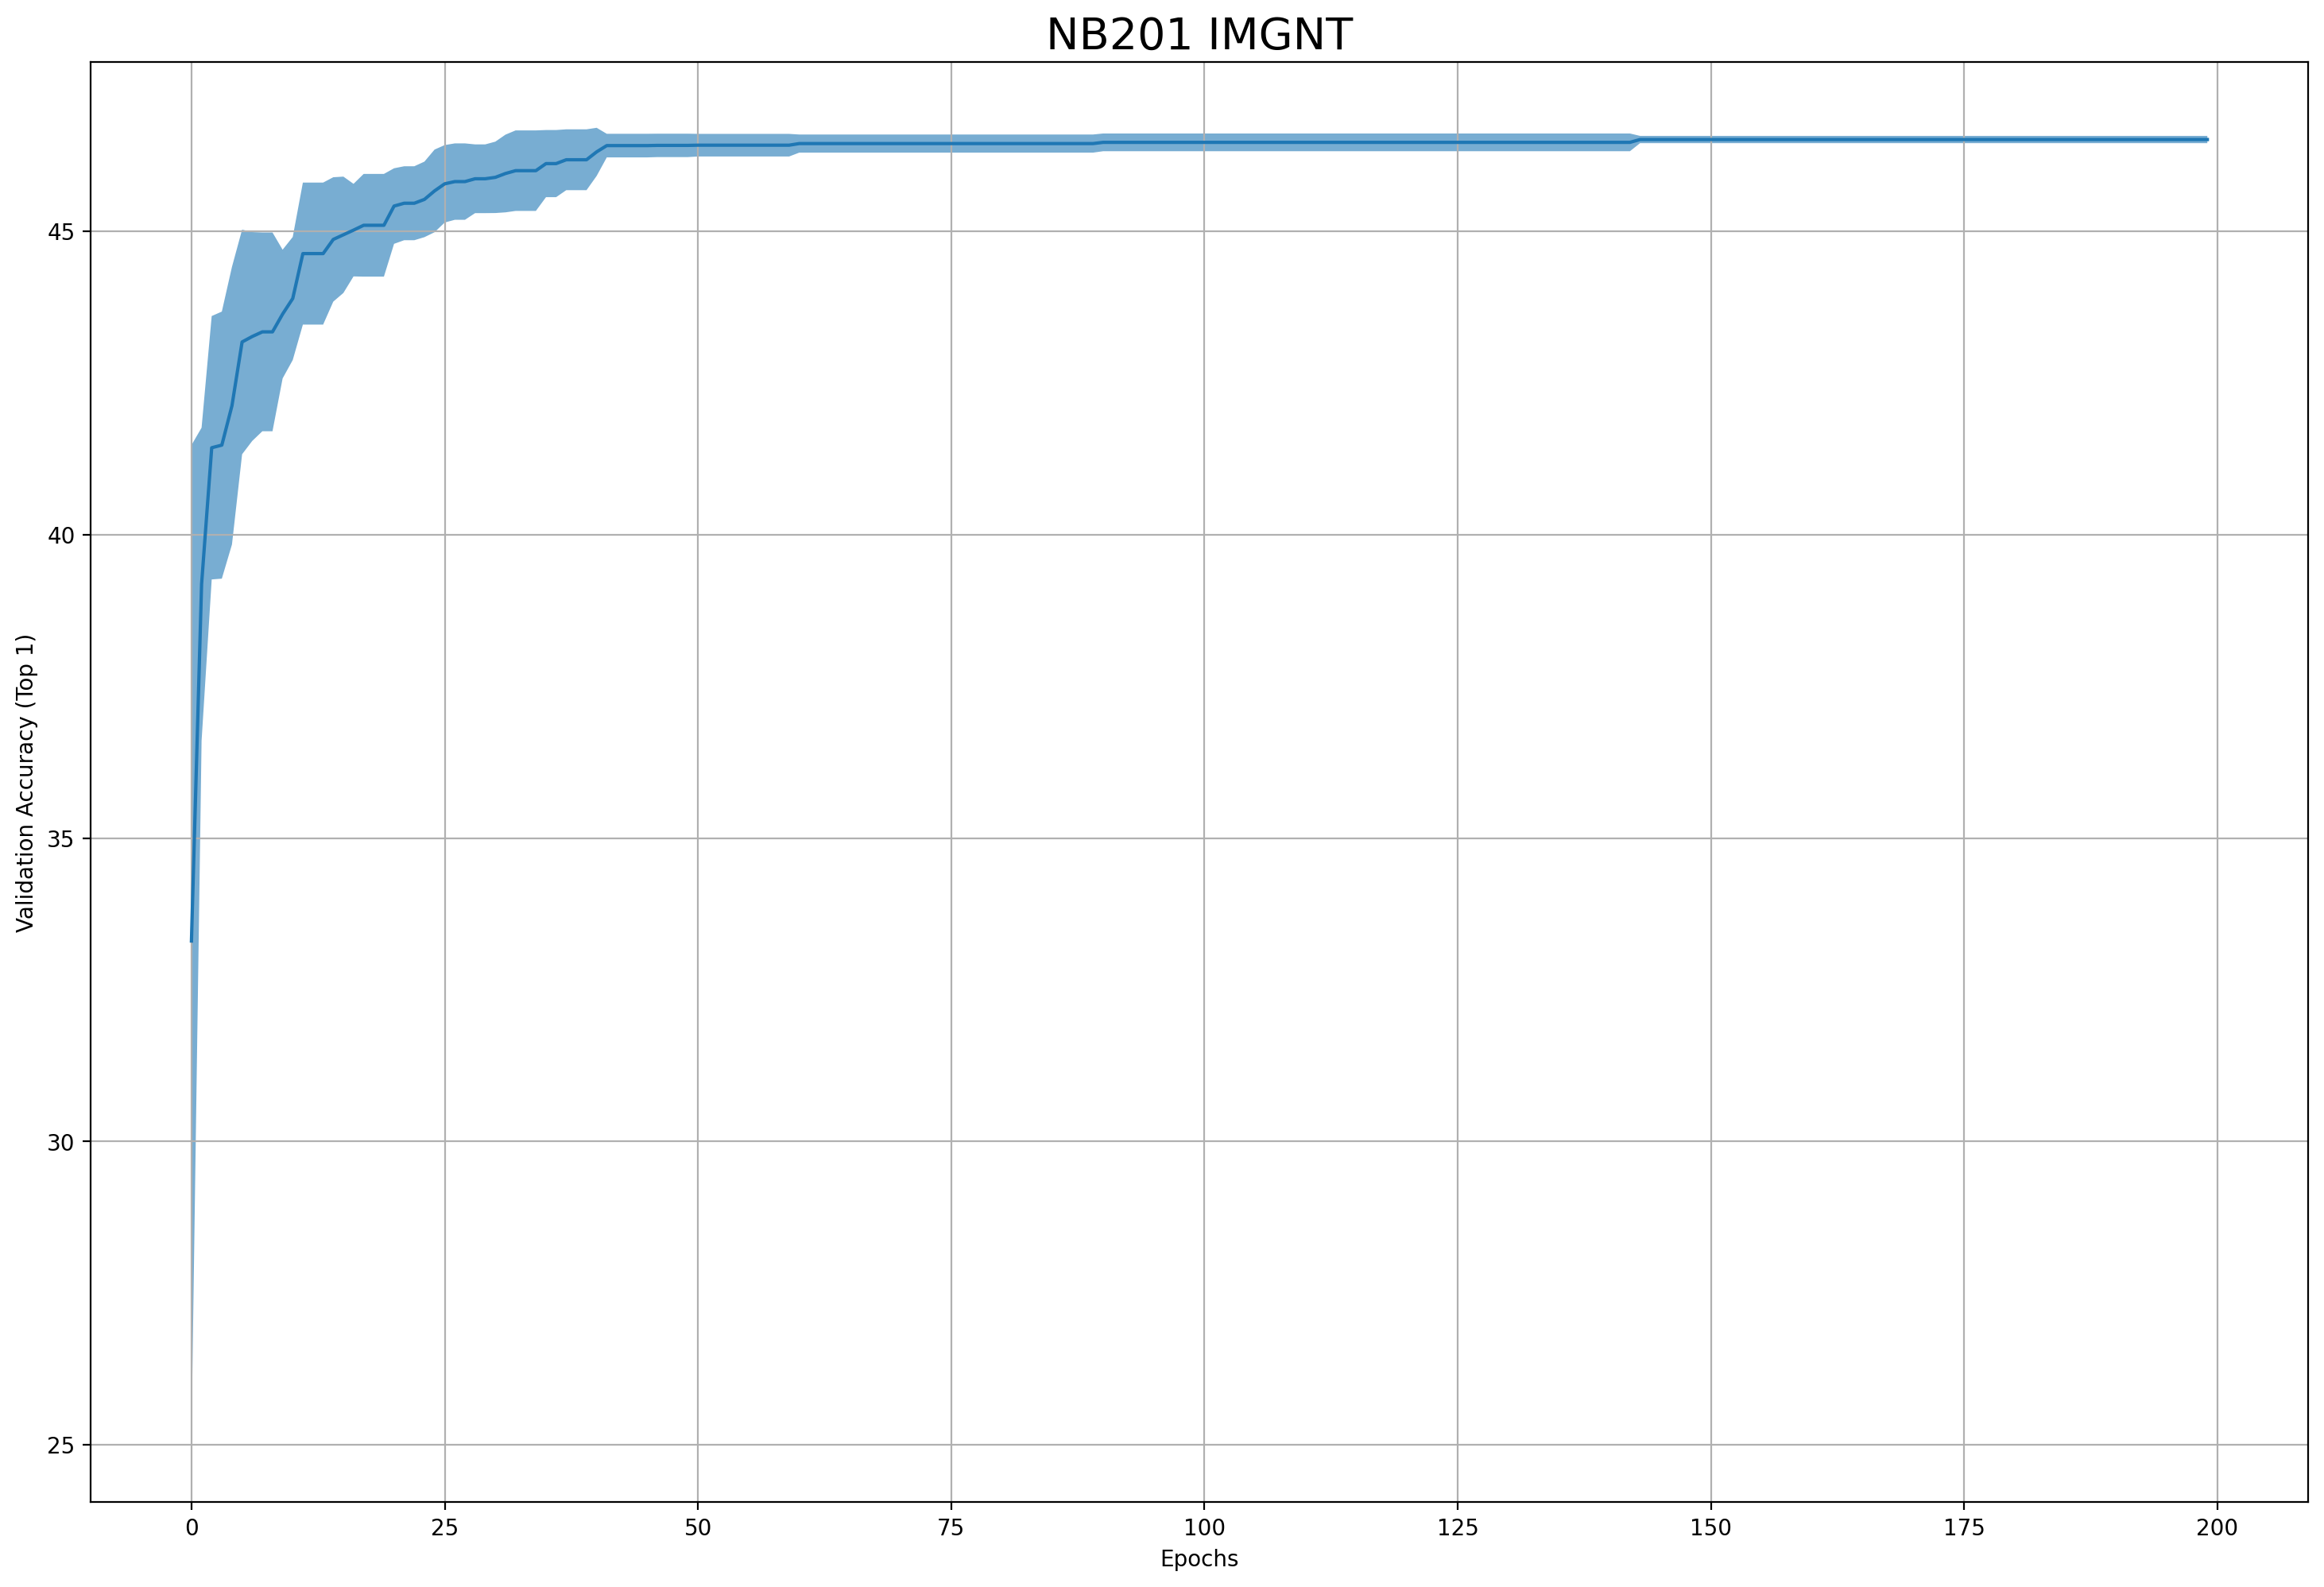

In [13]:
plot_for_search_space(df, 'nasbench201')